In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pickle
import random
import requests
import io
import zipfile
from scipy.stats import norm
from typing import Optional


from simulation_helpers import*
from Simulation_models import*

# Simulation: Regime-Switching Volatility Management

We simulate a three-assets (Growth, Carry, Defensive) across three persistent regimes (Bull, Neutral, Bear) with distinct volatility and return structures. VolTiming vs RL we train a volatility-timing model (4 seeds) that learns optimal portfolio weights for each regime using asset-specific volatility signals. Performance is evaluated "out-of-sample", meaning  testing seeds per training seed with the same structure. Otherwise MC-CWAR vs VolTime we used 4 seeds for simplicity

## Model: Volatility-Adjusted Allocation

**Problem:** Symmetric parameters with sum-to-one normalization kill timing — all assets scale proportionally by vol, so normalized weights remain constant. This happened in daily reallocation (see at the end). For monthly positions it was ok. So MW-CVAR vs VolTiming monthly rebalance + average std as a scaling factor. In case of VolTime vs RL: daily positions and optimization with stand alove std scaling factors ( similar to Demiguel et all appendix)



In [2]:

def simulate_markov_chain(Q, T, k0=0, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)
    Q = np.asarray(Q, float)
    K = Q.shape[0]
    if Q.shape != (K, K):
        raise ValueError("Q must be (K,K)")
    if not np.allclose(Q.sum(axis=1), 1.0):
        raise ValueError("Rows of Q must sum to 1.")
    k = np.empty(int(T), dtype=int)
    k[0] = int(k0)
    for t in range(1, int(T)):
        k[t] = rng.choice(K, p=Q[k[t - 1]])
    return k


def _as_3d_Phi(Phi, K, N):
    Phi = np.asarray(Phi, float)
    if Phi.ndim == 2:
        if Phi.shape != (N, N):
            raise ValueError("Phi (2D) must be (N,N)")
        return np.repeat(Phi[None, :, :], K, axis=0)
    if Phi.ndim == 3:
        if Phi.shape != (K, N, N):
            raise ValueError("Phi (3D) must be (K,N,N)")
        return Phi
    raise ValueError("Phi must be 2D (N,N) or 3D (K,N,N)")


def _expand_regime_param(x, K, fill_value):
    # ensures regime spec parameters have lengh k = regime
    if x is None:
        return np.full(K, fill_value, dtype=float)
    x = np.asarray(x, float).reshape(-1)
    if x.size < K:
        x = np.pad(x, (0, K - x.size), constant_values=float(fill_value))
    return x[:K]


def multivariate_t_eps_with_target_cov(rng, Sigma, df):
    """
    eps ~ multivariate Student-t(df) with scaling so that Cov(eps)=Sigma.
    We generate:
        z = L @ N(0,I)
        u ~ chi2(df)
        t_raw = z / sqrt(u/df)
        eps = t_raw * sqrt((df-2)/df)  (if df>2)
        https://en.wikipedia.org/wiki/Student%27s_t-distribution?utm_source=chatgpt.com
    """
    Sigma = np.asarray(Sigma, float)
    n = Sigma.shape[0]
    if Sigma.shape != (n, n):
        raise ValueError("Sigma must be square (N,N)")
    L = np.linalg.cholesky(Sigma + 1e-12 * np.eye(n))
    z = L @ rng.standard_normal(n)
    u = rng.chisquare(df)
    t_raw = z / np.sqrt(u / df)
    if df > 2.0:
        return np.sqrt((df - 2.0) / df) * t_raw
    return t_raw  # covariance is infinite if df<=2


def simulate_rs_var1_monthly_regimes_RS_SV_T(T_days,Q,c_list,Phi,Sigma_list,k0=0,burn_in_months=50,rng=None,
                                             start_date="2000-01-03",df_list=None,sv_rho=0.97,sv_sigma=0.20,
                                             logh_mu_list=None,return_h=False,
):

    if rng is None:
        rng = np.random.default_rng(0)

    Q = np.asarray(Q, float)
    c_list = np.asarray(c_list, float)
    Sigma_list = np.asarray(Sigma_list, float)

    K = Q.shape[0]
    if Q.shape != (K, K):
        raise ValueError("Q must be (K,K)")
    if not np.allclose(Q.sum(axis=1), 1.0):
        raise ValueError("Rows of Q must sum to 1.")

    if c_list.ndim != 2:
        raise ValueError("c_list must be (K,N)")
    if c_list.shape[0] != K:
        raise ValueError("c_list first dim must match K")
    N = c_list.shape[1]

    if Sigma_list.shape != (K, N, N):
        raise ValueError("Sigma_list must be (K,N,N) matching c_list")

    Phi_arr = _as_3d_Phi(Phi, K, N)

    df_list = _expand_regime_param(df_list, K, 8.0)
    logh_mu_list = _expand_regime_param(logh_mu_list, K, -1.5)

    # calendar
    T_days = int(T_days)
    sample_dates = pd.bdate_range(start_date, periods=T_days)
    start_month = sample_dates[0].to_period("M")
    end_month   = sample_dates[-1].to_period("M")

    sample_months = pd.period_range(start=start_month, end=end_month, freq="M")
    T_months = len(sample_months)

    burn_in_months = int(burn_in_months)
    full_months = pd.period_range(start=(start_month - burn_in_months), end=end_month, freq="M")
    TT_months = len(full_months)

    # monthly regimes
    k_month_full = simulate_markov_chain(Q, TT_months, k0=k0, rng=rng)

    # expand to business days (each month constant regime)
    all_dates_full = []
    k_days_full = []
    for m_idx, per in enumerate(full_months):
        month_start = per.to_timestamp(how="start")
        month_end   = per.to_timestamp(how="end")
        dts = pd.bdate_range(month_start, month_end)
        all_dates_full.append(dts)
        k_days_full.append(np.full(len(dts), int(k_month_full[m_idx]), dtype=int))

    all_dates_full = all_dates_full[0].append(all_dates_full[1:]) if len(all_dates_full) > 1 else all_dates_full[0]
    k_days_full = np.concatenate(k_days_full, axis=0)

    # simulate daily log returns
    T_full = len(all_dates_full)
    r_full = np.zeros((T_full, N), dtype=float)
    h_full = np.ones(T_full, dtype=float)

    # init log-vol at regime mean
    logh = float(logh_mu_list[int(k_days_full[0])])
    h_full[0] = float(np.exp(logh))

    sv_rho = float(sv_rho)
    sv_sigma = float(sv_sigma)

    for t in range(1, T_full):
        kt = int(k_days_full[t])
        df = float(df_list[kt])

        # SV(1) around regime mean
        mu_k = float(logh_mu_list[kt])
        logh = mu_k + sv_rho * (logh - mu_k) + sv_sigma * rng.standard_normal()
        h = float(np.exp(logh))
        h_full[t] = h

        eps = multivariate_t_eps_with_target_cov(rng, Sigma_list[kt], df=df)
        eps = np.sqrt(h) * eps  # Cov = h * Sigma_k

        r_full[t] = c_list[kt] + Phi_arr[kt] @ r_full[t - 1] + eps

    # drop burn-in by date indexing
    pos = all_dates_full.get_indexer(sample_dates)
    r_days = r_full[pos]
    k_days = k_days_full[pos]
    k_month = k_month_full[-T_months:] # so the original dates are aligned to the sample_months. no burn in here cause we already dropped by date indexing
    h_days = h_full[pos]

    if return_h:
        return r_days, k_days, k_month, sample_dates, sample_months, h_days
    return r_days, k_days, k_month, sample_dates, sample_months


# In-Sample Simulation Framework (No Saving)

This section simulates Markov regime-switching returns and evaluates strategies.
Outputs are displayed only (no files are saved).

In [3]:

class MarkovSimulationEnvironment:
    # TODO: loop over seed and test seeds, align with RL
    def __init__(self, Q, c_list, Phi, Sigma_list, regime_names,
                 T_days=252*30, seed=123, burn_in_months=50,
                 start_date="2000-01-03", k0=0, asset_names=None,
                 df_list=None, sv_rho=0.97, sv_sigma=0.20, logh_mu_list=None,
                 verbose: bool = False):
        """
        Q: Transition matrix (K x K)
        c_list: Drift per regime (K x N)
        Phi: AR(1) coefficient matrix (N x N) or (K x N x N), same
        Sigma_list: Covariance per regime (K x N x N)
        regime_names: List of regime names, align with Q and other parameters!
        df_list: Student-t df per regime (length K)
        sv_rho: persistence of log-vol (vol clustering)
        sv_sigma: innovation std of log-vol
        logh_mu_list: regime-specific mean level of log-vol (length K)
        """
        self.Q = np.asarray(Q, float)
        self.c_list = np.asarray(c_list, float)
        self.Phi = np.asarray(Phi, float)
        self.Sigma_list = np.asarray(Sigma_list, float)
        self.regime_names = regime_names
        self.T_days = T_days
        self.seed = seed
        self.burn_in_months = burn_in_months
        self.start_date = start_date
        self.k0 = k0
        self.verbose = verbose
        
        self.K = len(regime_names)
        self.N = self.c_list.shape[1]
        self.asset_names = asset_names or [f"Asset{i+1}" for i in range(self.N)]
        
        self.df_list = df_list
        self.sv_rho = sv_rho
        self.sv_sigma = sv_sigma
        self.logh_mu_list = logh_mu_list
        
        self.daily_returns_df = None
        self.monthly_returns_df = None
        self.daily_regimes = None
        self.monthly_regimes = None
        self.dates = None
        self.sample_months = None
        
    def _expand_regime_param(self, values, fill_value):
        values = np.asarray(values, float) if values is not None else None
        if values is None:
            return np.full(self.K, fill_value, dtype=float)
        if values.size < self.K:
            return np.pad(values, (0, self.K - values.size), constant_values=fill_value)
        return values[:self.K]
        
    def simulate(self):
        set_numpy_determinism(self.seed)
        rng = np.random.default_rng(self.seed)
    
        df_list = self._expand_regime_param(self.df_list, 8.0)
        logh_mu_list = self._expand_regime_param(self.logh_mu_list, -1.0)
        sv_rho = float(self.sv_rho)
        sv_sigma = float(self.sv_sigma)
    
        r_log, k_daily, k_month, dates, sample_months = simulate_rs_var1_monthly_regimes_RS_SV_T(
            T_days=self.T_days,
            Q=self.Q,
            c_list=self.c_list,
            Phi=self.Phi,
            Sigma_list=self.Sigma_list,
            k0=self.k0,
            burn_in_months=self.burn_in_months,
            rng=rng,
            start_date=self.start_date,
            df_list=df_list,
            sv_rho=sv_rho,
            sv_sigma=sv_sigma,
            logh_mu_list=logh_mu_list,
        )
    
        # Convert log returns to simple returns !!!!!
        r_simple = np.exp(r_log) - 1.0
    
        self.daily_returns_df = pd.DataFrame(
            r_simple,
            index=dates,
            columns=self.asset_names
        )
    
        self.daily_regimes = (
            pd.Series(k_daily, index=dates, name="regime_int")
            .map(lambda x: self.regime_names[int(x)])
        ) # bull, neutral, bear mapping based on position!
        self.daily_regimes.name = "regime"
    
        self.monthly_returns_df = compute_monthly_factor_returns_from_daily(
            self.daily_returns_df,
            factor_cols=self.asset_names
        )
    
        # Build monthly regimes indexed EXACTLY like monthly_returns_df.index!!!!!
        # k_month is aligned to sample_months (PeriodIndex, monthly)
        k_month_ser = pd.Series(k_month, index=sample_months, name="regime_int")
    
        idx = self.monthly_returns_df.index  # last trading day timestamps
        self.monthly_regimes = (
            k_month_ser
            .reindex(idx.to_period("M"))          # month period -> regime int
            .set_axis(idx)                        # index = last trading day timestamps
            .map(lambda x: self.regime_names[int(x)])  # int -> regime name !!!
        )
        self.monthly_regimes.name = "regime"
    
        self.dates = dates
        self.sample_months = sample_months
    
        if self.verbose:
            ok = self.monthly_regimes.index.equals(self.monthly_returns_df.index)
            print(f"  Simulated {len(self.daily_returns_df):,} days across {len(self.monthly_returns_df)} months")
            print(f"  Monthly regime index aligned to monthly returns: {ok}")
            print(f"  Daily regime distribution: {self.daily_regimes.value_counts().to_dict()}")
    
        return self
    

    
    def save_simulation_data(self, filepath):
        """Save all simulation data to pickle"""
        data = {
            'daily_returns': self.daily_returns_df,
            'monthly_returns': self.monthly_returns_df,
            'daily_regimes': self.daily_regimes,
            'monthly_regimes': self.monthly_regimes,
            'dates': self.dates,
            'sample_months': self.sample_months,
            'parameters': {
                'Q': self.Q,
                'c_list': self.c_list,
                'Phi': self.Phi,
                'Sigma_list': self.Sigma_list,
                'regime_names': self.regime_names,
                'seed': self.seed,
                'asset_names': self.asset_names,
                'df_list': self.df_list,
                'sv_rho': self.sv_rho,
                'sv_sigma': self.sv_sigma,
                'logh_mu_list': self.logh_mu_list
            },
        }
        
        with open(filepath, 'wb') as f:
            pickle.dump(data, f)
        if self.verbose:
            print(f" Saved simulation data to {filepath}")
        
    @staticmethod
    def load_simulation_data(filepath):
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        print(f" Loaded simulation data from {filepath}")
        return data

In [4]:
class StrategyBacktester:

    
    def __init__(self, env, verbose: bool = False):
        self.env = env
        self.results = {}
        self.verbose = verbose

    def _log(self, msg: str):
        if self.verbose:
            print(msg)
        
    def run_volatility_management(self, name="VolManagement", ridge=1e-8, gamma=3.0, c_tc=0.0021):
        self._log(f"\n[{name}] Running...")
        
        result = Markowitz_with_turnover_TC_diffobj(
            daily_factors=self.env.daily_returns_df,
            factor_cols=self.env.asset_names,
            gamma=gamma,
            ridge=ridge,
            nonneg=True,
            c_tc=c_tc,
            use_drift_turnover=True,
            bounded_b=False  # Allow volatility timing via b parameters
        )
        
        # Compute daily returns from monthly weights
        # check this. do we scale with Mkt-rf?
        daily_port_returns = daily_portfolio_returns_from_monthly_weights(
            self.env.daily_returns_df,
            result['weights']
        )
        
        # Get weights by regime
        weights_by_regime = self._compute_weights_by_regime_markowitz(
            result['weights']
        )
        
        self.results[name] = {
            'daily_returns': daily_port_returns,
            'monthly_returns': result['portfolio_returns_net'],
            'weights_monthly': result['weights'],
            'turnover': result['turnover'],
            'costs': result['costs'],
            'a_params': result['a'],
            'b_params': result['b'],
            'weights_by_regime': weights_by_regime,
            'type': 'VolManagement'
        }
        
        self._log(f"   Vol-timing params (b): {result['b'].round(4).to_dict()}")
        return self
    def run_volatility_management_daily(self, name="VolManagement_daily",
                                   ridge=1e-8, gamma=3.0, c_tc=0.0001, vol_window=20):
        self._log(f"\n[{name}] Running...")

        result = Markowitz_with_turnover_TC_diffobj_daily(
            daily_factors=self.env.daily_returns_df,
            factor_cols=self.env.asset_names,
            gamma=gamma,
            ridge=ridge,
            nonneg=True,
            c_tc=c_tc,
            use_drift_turnover=True,
            vol_window=vol_window,
            bounded_b=False
        )

        # These are DAILY objects:
        w_daily   = result["weights"]                # DataFrame, daily index
        rport_net = result["portfolio_returns_net"]  # Series, daily index

        # If you want weights-by-regime, use DAILY regimes (aligned on dates)

        self.results[name] = {
            "portfolio_returns_daily": rport_net,   
            "weights_daily": w_daily,
            "turnover_daily": result["turnover"],
            "costs_daily": result["costs"],
            "a_params": result["a"],
            "b_params": result["b"],
            "type": "VolManagement",
        }

        self._log(f"   Vol-timing params (b): {result['b'].round(4).to_dict()}")
        return self

    
    def run_markowitz(self, name="Markowitz", gamma=3.0, c_tc=0.0021, 
                        use_drift_turnover=True, bounded_b=True, ridge=1e-8):
        self._log(f"\n[{name}] Running...")
        
        result = Markowitz_with_turnover_TC_diffobj(
            daily_factors=self.env.daily_returns_df,
            factor_cols=self.env.asset_names,
            gamma=gamma,
            ridge=ridge,
            nonneg=True,
            c_tc=c_tc,
            use_drift_turnover=use_drift_turnover,
            bounded_b=bounded_b # no volatility timing.
        )
        
        daily_port_returns = daily_portfolio_returns_from_monthly_weights(
            self.env.daily_returns_df,
            result['weights']
        )
        
        weights_by_regime = self._compute_weights_by_regime_markowitz(
            result['weights']
        )
        
        self.results[name] = {
            'daily_returns': daily_port_returns,
            'monthly_returns': result['portfolio_returns_net'],
            'weights_monthly': result['weights'],
            'turnover': result['turnover'],
            'costs': result['costs'],
            'a_params': result['a'],
            'b_params': result['b'],
            'weights_by_regime': weights_by_regime,
            'type': 'Markowitz'
        }
        
        self._log(f"  Avg monthly turnover: {result['turnover'].mean():.4f}")
        return self

    def run_equal_weight(self, name="EqualWeight"):
        self._log(f"\n[{name}] Running...")
        
        weights = pd.Series(
            1.0 / self.env.N, 
            index=self.env.asset_names
        )
        
        daily_port_returns = (self.env.daily_returns_df @ weights)
        monthly_port_returns = (1 + daily_port_returns).groupby(
            daily_port_returns.index.to_period("M")
        ).prod() - 1.0
        monthly_port_returns.index = monthly_port_returns.index.to_timestamp("M")
        
        weights_by_regime = pd.DataFrame(
            {regime: weights for regime in self.env.regime_names}
        ).T
        
        self.results[name] = {
            'daily_returns': daily_port_returns,
            'monthly_returns': monthly_port_returns,
            'weights': weights,
            'weights_by_regime': weights_by_regime,
            'type': 'EqualWeight'
        }
        
        return self

    def run_mv_simple(self, name="MV_Simple", gamma=3.0, ridge=1e-10, 
                        sum_to_one_constraint=True, long_only=True):
        self._log(f"\n[{name}] Running...")
        
        result = mv_simple(
            daily_ret=self.env.daily_returns_df,
            cols=self.env.asset_names,
            gamma=gamma,
            ridge=ridge,
            sum_to_one_constraint=sum_to_one_constraint,
            long_only=long_only
        )
        
        weights_series = result['weights']
        daily_port_returns = (self.env.daily_returns_df @ weights_series)
        
        weights_by_regime = pd.DataFrame(
            {regime: weights_series for regime in self.env.regime_names}
        ).T
        
        self.results[name] = {
            'daily_returns': daily_port_returns,
            'monthly_returns': result['port_monthly'],
            'weights': weights_series,
            'weights_by_regime': weights_by_regime,
            'type': 'MV_Simple'
        }
        
        self._log(f"   Weights: {weights_series.round(4).to_dict()}")
        return self

    def run_mw_cvar_simple(self, name="MV_CVaR", beta=0.95, gamma=3.0,
                            sum_to_one_constraint=True, long_only=True, 
                            upper_bound=1.0, solver="ECOS"):
        self._log(f"\n[{name}] Running...")
        

        
        result = mw_cvar_simple(
            daily_ret=self.env.daily_returns_df,
            cols=self.env.asset_names,
            beta=beta,
            gamma=gamma,
            sum_to_one_constraint=sum_to_one_constraint,
            long_only=long_only,
            upper_bound=upper_bound,
            solver=solver,
            verbose=False
        )
        
        weights_series = result['weights']
        daily_port_returns = (self.env.daily_returns_df @ weights_series)
        
        weights_by_regime = pd.DataFrame(
            {regime: weights_series for regime in self.env.regime_names}
        ).T
        
        self.results[name] = {
            'daily_returns': daily_port_returns,
            'monthly_returns': result['port_monthly'],
            'weights': weights_series,
            'weights_by_regime': weights_by_regime,
            'cvar_loss': result['cvar_loss'],
            'type': 'MV_CVaR'
        }
        
        self._log(f"   Weights: {weights_series.round(4).to_dict()}")
        self._log(f"   CVaR (loss): {result['cvar_loss']:.6f}")
        return self

    def _compute_weights_by_regime_markowitz(self, weights_monthly):
        common = weights_monthly.index.intersection(self.env.monthly_regimes.index)
        
        regime_weights = []
        for regime in self.env.regime_names:
            mask = self.env.monthly_regimes.loc[common] == regime
            if mask.sum() == 0:
                continue
            
            avg_weights = weights_monthly.loc[common][mask].mean()
            
            weights = avg_weights.to_dict()
            weights['Regime'] = regime
            regime_weights.append(weights)
        
        return pd.DataFrame(regime_weights).set_index('Regime')

    def save_results(self, filepath):
        data = {
            'results': self.results,
            'environment': {
                'regime_names': self.env.regime_names,
                'asset_names': self.env.asset_names,
                'seed': self.env.seed
            }
        }
        
        with open(filepath, 'wb') as f:
            pickle.dump(data, f)
        if self.verbose:
            print(f"Saved backtest results to {filepath}")

## Run All Scenarios and Generate Comprehensive Tables



In [ ]:


# MV_CVaR vs VolManagement 
# MONTHLY
# lets use gamma = 3 everywhere... for simplicity

regime_names = ["Bull", "Neutral", "Bear"] # ! align with the parameters as intended.
asset_names  = ["Asset1_Growth", "Asset2_Carry", "Asset3_Defensive"]

GAMMA   = 3.0 # difficult to interpret the gamma here in case of cvar.
seeds   = [53, 274, 1234, 89]
TIE_EPS = 1e-6




Phi_fixed = np.array([
    [0.15, 0.10, 0.10],
    [0.10, 0.15, 0.10],
    [0.10, 0.10, 0.15],
], dtype=float)
Phi_k = np.tile(Phi_fixed, (3, 1, 1))

c_base = np.array([
    [0.00120, 0.00020, 0.00070],  # Bull
    [0.00080, 0.00018, 0.00060],  # Neutral
    [0.00040, 0.00015, 0.00050],  # Bear
], dtype=float)

Sigma_base = np.array([
    # Bull
    [[0.00020000, 0.00008000, 0.00006300],
     [0.00008000, 0.00016000, 0.00005600],
     [0.00006300, 0.00005600, 0.00018000]],
    # Neutral
    [[0.00032400, 0.00013000, 0.00010800],
     [0.00013000, 0.00025600, 0.00009000],
     [0.00010800, 0.00009000, 0.00028900]],
    # Bear
    [[0.00062500, 0.00015000, -0.00010000],
     [0.00015000, 0.00040000,  0.00008000],
     [-0.00010000, 0.00008000, 0.00048400]],
], dtype=float)


# TAIL-SHOCK dominates: MV_CVaR should win 
# Interpretation:
#   - Crashes are big but short and no vol clustering
#   - MV_CVaR wins by structurally avoiding tail-exposed mixes -> lower realized vol

Q_tailshock = np.array([
    [0.997, 0.002, 0.001],  # Bull is very persistent
    [0.080, 0.900, 0.020],  # Neutral somewhat persistent
    [0.985, 0.010, 0.005],   # Bear is not persistent and switch immediately
], dtype=float)

df_tailshock = np.array([25.0, 10.0, 2.2], dtype=float)        # extreme Bear tails and decreasing gaussian per regime ( bull, neutral, bear)
logh_mu_tailshock = np.array([-3.0, -2.4, 0.35], dtype=float)   # Bear scale spikes
sv_rho_tailshock, sv_sigma_tailshock = 0.20, 0.90              # NOT persistent => timing weak, but the Q matrix is persistant and huge sigma


# VOL-TIMING dominates
# Interpretation:
#   - Volatility is persistent and regime-separated (clustering)
#   - Scaling exposure during high-vol periods reduces realized std a lot

Q_voltiming = np.array([
    [0.94, 0.05, 0.01],       # Persistent Bull
    [0.10, 0.80, 0.10],     # Neutral somewhat persistent   
    [0.02, 0.03, 0.95],      # Bear very persistent
], dtype=float)

# we need to specify these as well as model dependent. If we would have cash...
df_voltiming = np.array([25.0, 15.0, 12.0], dtype=float) # tail risk intensity.
logh_mu_voltiming = np.array([-4.0, -2.6, -0.8], dtype=float)  # big regime vol gaps
sv_rho_voltiming, sv_sigma_voltiming = 0.995, 0.25             # persistent => timing strong


targeted_scenarios = [
    dict(
        name="TailShockWorld_Sharpe",
        Q=Q_tailshock, c=c_base, Sigma=Sigma_base,
        df_list=df_tailshock, logh_mu_list=logh_mu_tailshock,
        sv_rho=sv_rho_tailshock, sv_sigma=sv_sigma_tailshock,
        winner_metric="Sharpe (ann.)",
        expected_winner="MV_CVaR",
        mv_cvar_beta=0.95,
    ),
    dict(
        name="VolTimingWorld_Sharpe",
        Q=Q_voltiming, c=c_base, Sigma=Sigma_base,
        df_list=df_voltiming, logh_mu_list=logh_mu_voltiming,
        sv_rho=sv_rho_voltiming, sv_sigma=sv_sigma_voltiming,
        winner_metric="Sharpe (ann.)",
        expected_winner="VolManagement",
        mv_cvar_beta=0.95,
    ),
]


targeted_results = {}
targeted_tables  = {}
volmanagement_params_monthly = {}

for scen in targeted_scenarios:
    scenario_name   = scen["name"]
    Q_matrix        = scen["Q"]
    c_scenario      = scen["c"]
    Sigma_scenario  = scen["Sigma"]

    mv_cvar_beta    = scen["mv_cvar_beta"]
    winner_metric   = scen["winner_metric"]
    expected_winner = scen["expected_winner"]

    perf_tables = []
    volmanagement_params_monthly[scenario_name] = {}

    for seed in seeds:
        env = MarkovSimulationEnvironment(
            Q=Q_matrix,
            c_list=c_scenario,
            Phi=Phi_k, # common 
            Sigma_list=Sigma_scenario,
            regime_names=regime_names,
            T_days=252 * 70,
            seed=seed,
            burn_in_months=50,
            start_date="2000-01-03",
            k0=0,
            asset_names=asset_names,
            verbose=False,

            df_list=scen["df_list"],
            sv_rho=scen["sv_rho"],
            sv_sigma=scen["sv_sigma"],
            logh_mu_list=scen["logh_mu_list"],
        )
        env.simulate() # initialize returns

        backtester_monthly = StrategyBacktester(env, verbose=False)

        # ONLY the two main strategies
        backtester_monthly.run_mw_cvar_simple("MV_CVaR", beta=mv_cvar_beta, gamma=GAMMA) # !!!!!!!!
        backtester_monthly.run_volatility_management("VolManagement", gamma=GAMMA, c_tc=0.0021) # !!!! nonneg= True, bounded_b = False and use_drift_turnover = True

        # "no timing" baseline
        backtester_monthly.run_markowitz(
            "VolManagement_Unconditional",
            gamma=GAMMA,
            c_tc=0.0021,
            use_drift_turnover=True,
            bounded_b=True
        )

        portfolios = {name: data["monthly_returns"] for name, data in backtester_monthly.results.items()}
        perf_table = make_table_for_portfolios(portfolios, periods_per_year=12)
        perf_tables.append(perf_table)
        
        # Store VolManagement a/b parameters for this seed
        volmanagement_params_monthly[scenario_name][seed] = {
            'a_params': backtester_monthly.results['VolManagement']['a_params'],
            'b_params': backtester_monthly.results['VolManagement']['b_params']
        }

    common_index = perf_tables[0].index
    common_cols  = perf_tables[0].columns
    perf_tables  = [t.reindex(index=common_index, columns=common_cols) for t in perf_tables]
    mean_table = sum(perf_tables) / len(perf_tables)

    print("\n" + "-" * 60)
    print(f"MEAN MONTHLY PERFORMANCE TABLE (across {len(seeds)} seeds): {scenario_name}")
    print("-" * 60)
    print(mean_table.round(3).to_string())



    targeted_results[scenario_name] = {
        "mean_perf_table": mean_table,                  
        "winner_metric": winner_metric,
        "expected_winner": expected_winner,
        "seeds": seeds,
        "gamma": GAMMA,
        "mv_cvar_beta": mv_cvar_beta,
    }
    targeted_tables[scenario_name] = mean_table


Using factor columns: ['Asset1_Growth', 'Asset2_Carry', 'Asset3_Defensive']
Using factor columns: ['Asset1_Growth', 'Asset2_Carry', 'Asset3_Defensive']
Using factor columns: ['Asset1_Growth', 'Asset2_Carry', 'Asset3_Defensive']
Using factor columns: ['Asset1_Growth', 'Asset2_Carry', 'Asset3_Defensive']
Using factor columns: ['Asset1_Growth', 'Asset2_Carry', 'Asset3_Defensive']
Using factor columns: ['Asset1_Growth', 'Asset2_Carry', 'Asset3_Defensive']
Using factor columns: ['Asset1_Growth', 'Asset2_Carry', 'Asset3_Defensive']
Using factor columns: ['Asset1_Growth', 'Asset2_Carry', 'Asset3_Defensive']

------------------------------------------------------------
MEAN MONTHLY PERFORMANCE TABLE (across 4 seeds): TailShockWorld_Sharpe
------------------------------------------------------------
                          MV_CVaR  VolManagement  VolManagement_Unconditional
Ann. Mean (%)              39.044         42.451                       42.512
Ann. StdDev (%)             8.216         

In [6]:
backtester_monthly.results['VolManagement']['weights_monthly']

,Asset1_Growth,Asset2_Carry,Asset3_Defensive
2000-02-29,0.393394,1.542697e-16,0.606606
2000-03-31,0.393220,1.542411e-16,0.606780
2000-04-28,0.391234,1.539156e-16,0.608766
2000-05-31,0.395456,1.546077e-16,0.604544
2000-06-30,0.401208,1.555504e-16,0.598792
...,...,...,...
2067-04-29,0.435783,1.612175e-16,0.564217
2067-05-31,0.428054,1.599508e-16,0.571946
2067-06-30,0.435090,1.611039e-16,0.564910
2067-07-29,0.456644,1.646368e-16,0.543356


In [7]:
backtester_monthly.results['VolManagement']['a_params'],backtester_monthly.results['VolManagement']['b_params']

(Asset1_Growth       1.067859e+00
 Asset2_Carry        2.709131e-16
 Asset3_Defensive    1.093036e-16
 Name: a, dtype: float64,
 Asset1_Growth       9.085695e-02
 Asset2_Carry        3.593036e-17
 Asset3_Defensive    1.434493e-01
 Name: b, dtype: float64)

In [50]:
volmanagement_params_monthly.keys()

dict_keys(['TailShockWorld_Sharpe', 'VolTimingWorld_Sharpe'])

In [51]:
# Average a_params and b_params per scenario across seeds
import pandas as pd

avg_params_by_scenario = {}

for scenario_name, seed_dict in volmanagement_params_monthly.items():
    a_params_list = []
    b_params_list = []
    
    for seed, params in seed_dict.items():
        a_params_list.append(params['a_params'])
        b_params_list.append(params['b_params'])
    
    a_df = pd.DataFrame(a_params_list)
    b_df = pd.DataFrame(b_params_list)
    
    avg_params_by_scenario[scenario_name] = {
        'a_avg': a_df.mean(),
        'b_avg': b_df.mean()
    }
    
    print(f"\n{'='*60}")
    print(f"Scenario: {scenario_name}")
    print(f"{'='*60}")
    print(f"\nAverage a_params (across {len(seed_dict)} seeds):")
    print(avg_params_by_scenario[scenario_name]['a_avg'].round(4))
    print(f"\nAverage b_params (across {len(seed_dict)} seeds):")
    print(avg_params_by_scenario[scenario_name]['b_avg'].round(4))


Scenario: TailShockWorld_Sharpe

Average a_params (across 4 seeds):
Asset1_Growth       0.1676
Asset2_Carry        0.1642
Asset3_Defensive    0.1660
dtype: float64

Average b_params (across 4 seeds):
Asset1_Growth       0.4229
Asset2_Carry        0.0000
Asset3_Defensive    0.0000
dtype: float64

Scenario: VolTimingWorld_Sharpe

Average a_params (across 4 seeds):
Asset1_Growth       0.2670
Asset2_Carry        1.8017
Asset3_Defensive    0.4492
dtype: float64

Average b_params (across 4 seeds):
Asset1_Growth       0.0298
Asset2_Carry        0.3558
Asset3_Defensive    0.5925
dtype: float64


In [8]:
# positive definite check!!

Sigma_k = np.array([
# Bull: moderate risk, mild diversification from A3
[[0.000220, 0.000080, -0.000030],
    [0.000080, 0.000100, -0.000010],
    [-0.000030,-0.000010, 0.000140]],

# Neutral: a bit more risk/correlation
[[0.000320, 0.000110, -0.000035],
    [0.000110, 0.000130, -0.000015],
    [-0.000035,-0.000015, 0.000170]],

# Bear: A1 risk explodes; A3 is a *true* hedge (strong negative cov with A1)
[[0.001500,-0.000150, -0.000650],
    [-0.000150,0.000220,  0.000020],
    [-0.000650,0.000020,  0.000500]],
], dtype=float)
def ensure_pd(S, eps=1e-10):
    """Return (is_pd, S_fixed). If not PD, adds diagonal jitter to make it PD."""
    S = 0.5 * (S + S.T)  # symmetrize
    try:
        np.linalg.cholesky(S)
        return True, S
    except np.linalg.LinAlgError:
        # shift diagonal so smallest eigenvalue becomes eps
        lam_min = np.min(np.linalg.eigvalsh(S))
        shift = (eps - lam_min) if lam_min < eps else eps
        S_fixed = S + shift * np.eye(S.shape[0])
        return False, S_fixed
        

ok, Sigma0 = ensure_pd(Sigma_k[0])
Sigma_k[0] = Sigma0
ok

True

In [ ]:
# Daily running to make it comparable to RL

In [10]:
# trainins seeds, test seeds 
def fit_volmanagement_ab_daily(
    daily_factors: pd.DataFrame,
    factor_cols,
    gamma=3.0,
    ridge=1e-8,
    c_tc=0.0001,
    vol_window=42,
    use_drift_turnover=True,
    bounded_b=False,
):
    """
    Train step: estimate a,b using Markowitz_with_turnover_TC_diffobj_daily on TRAIN data.
    Returns:a,b
    """
    res = Markowitz_with_turnover_TC_diffobj_daily(
        daily_factors=daily_factors,
        factor_cols=factor_cols,
        gamma=gamma,
        ridge=ridge,
        nonneg=True,
        c_tc=c_tc,
        use_drift_turnover=use_drift_turnover,
        vol_window=vol_window,
        bounded_b=bounded_b,
    )
    return res["a"], res["b"], res

def apply_volmanagement_ab_daily(
    daily_factors: pd.DataFrame,
    factor_cols,
    a: pd.Series,
    b: pd.Series,
    c_tc=0.0001,
    vol_window=42,
    use_avg_vol_proxy=True,
    use_assetwise_vol_proxy=False,  # NEW boolean !!!!!!!
    market_vol_proxy=None,
    abs_eps=1e-10,
    use_drift_turnover=True,
):
    """
    Test step: apply fixed (a,b) to TEST data to get daily weights and daily net portfolio returns.
    use_avg_vol_proxy:  s = X.rolling(int(vol_window)).std(ddof=1).mean(axis=1)
    use_assetwise_vol_proxy: if True, use per-asset rolling std so s is (T,N) not (T,).
    """
    factor_cols = [c for c in factor_cols if (market_vol_proxy is None or c != market_vol_proxy)]

    X = daily_factors[factor_cols].copy().dropna(how="any")  # daily simple returns!!!!!!!
    if X.empty:
        raise ValueError("No usable daily data after dropping NaNs.")

    # VOl signal!!!!!
    if (market_vol_proxy is not None) and (market_vol_proxy in daily_factors.columns):
        proxy = daily_factors.loc[X.index, market_vol_proxy].astype(float)
        s = proxy.rolling(int(vol_window)).std(ddof=1)  # scalar proxy
    else:
        if use_assetwise_vol_proxy:
            # NEW: asset-specific vol, s is a DataFrame (T,N)
            s = X.rolling(int(vol_window)).std(ddof=1)
        else:
            # OLD: scalar vol
            if use_avg_vol_proxy:
                s = X.rolling(int(vol_window)).std(ddof=1).mean(axis=1)
            else:
                proxy = X.mean(axis=1)
                s = proxy.rolling(int(vol_window)).std(ddof=1)

    # Create the testing set
    s = s.shift(1)  # one-day ahead
    valid = s.notna()

    # If s is DataFrame, valid is DataFrame -> reduce to row mask
    if isinstance(valid, pd.DataFrame):
        valid = valid.all(axis=1)

    Xv = X.loc[valid]
    if Xv.empty:
        raise ValueError("No usable test rows after volatility window / shift.")

    # Build sv with correct shape
    if use_assetwise_vol_proxy and isinstance(s, pd.DataFrame):
        # sv: (T,N)
        sv = s.loc[valid, Xv.columns].to_numpy()
    else:
        # sv: (T,1)
        sv = s.loc[valid].to_numpy().reshape(-1, 1)

    sv = np.maximum(sv, 1e-12)

    R = Xv.to_numpy()
    T, N = R.shape

    # align a,b to columns
    a_vec = a.reindex(Xv.columns).to_numpy().reshape(1, -1)
    b_vec = b.reindex(Xv.columns).to_numpy().reshape(1, -1)

    # theta_t = a + b / s_t
    theta = a_vec + (b_vec / sv)   # works for both (T,1) and (T,N)

    # fully invested normalization
    denom = theta.sum(axis=1, keepdims=True)
    theta = theta / np.where(np.abs(denom) > 1e-12, denom, 1.0)

    weights = pd.DataFrame(theta, index=Xv.index, columns=Xv.columns)

    def smooth_abs(x):
        return np.sqrt(x * x + abs_eps)

    # tau_series part
    taus = np.zeros(T, dtype=float)
    if use_drift_turnover and T > 1:
        for t in range(1, T):
            w_prev_post = theta[t - 1]
            R_prev = R[t - 1]
            g = 1.0 + R_prev

            numer = w_prev_post * g
            denom = float(np.sum(numer))
            w_pre = numer / denom if abs(denom) > 1e-12 else w_prev_post

            w_target = theta[t]
            taus[t] = 0.5 * float(np.sum(smooth_abs(w_target - w_pre)))

    turnover = pd.Series(taus, index=Xv.index, name="turnover")
    costs = pd.Series(c_tc * taus, index=Xv.index, name="costs")

    port_ret_gross = (weights * Xv).sum(axis=1)
    port_ret_net = port_ret_gross - costs

    # store vol_signal for debugging
    if use_assetwise_vol_proxy and isinstance(s, pd.DataFrame):
        vol_signal = s.loc[valid, Xv.columns].copy()
    else:
        vol_signal = pd.Series(s.loc[valid].values, index=Xv.index, name="s_lag")

    return {
        "weights": weights,
        "portfolio_returns_gross": port_ret_gross,
        "portfolio_returns_net": port_ret_net,
        "turnover": turnover,
        "costs": costs,
        "vol_signal": vol_signal,
    }


def run_volmanagement_oos_for_scenario(
    scenario_name: str,
    Q_matrix: np.ndarray,
    c_list: np.ndarray,
    Phi_k: np.ndarray,
    Sigma_list: np.ndarray,
    regime_names,
    asset_names,
    df_list,
    logh_mu_list,
    sv_rho,
    sv_sigma,
    train_seeds,
    test_seeds,
    train_T_days=252*30,
    test_T_days=252*20,
    burn_in_months_train=50,
    burn_in_months_test=0,
    start_date="2000-01-03",
    gamma=3.0,
    ridge=1e-8,
    c_tc=0.0001,
    vol_window=42,
    use_avg_vol_proxy=True,           
    use_assetwise_vol_proxy=False,    
):
    """
    Returns nested dict:
      out[train_seed][test_seed] = payload
    payload contains RL-like keys: port_ret_net, regime_days, weights, turnover, costs, a_params, b_params
    """
    out = {}

    for train_seed in train_seeds:
        env_tr = MarkovSimulationEnvironment(
            Q=Q_matrix, c_list=c_list, Phi=Phi_k, Sigma_list=Sigma_list,
            regime_names=regime_names, T_days=train_T_days, seed=train_seed,
            burn_in_months=burn_in_months_train, start_date=start_date, k0=0,
            asset_names=asset_names, verbose=False,
            df_list=df_list, sv_rho=sv_rho, sv_sigma=sv_sigma, logh_mu_list=logh_mu_list,
        ).simulate()

        a_hat, b_hat, _ = fit_volmanagement_ab_daily(
            daily_factors=env_tr.daily_returns_df,
            factor_cols=env_tr.asset_names,
            gamma=gamma,
            ridge=ridge,
            c_tc=c_tc,
            vol_window=vol_window,
            use_drift_turnover=True,
            bounded_b=False,
        )

        out[int(train_seed)] = {}

        for test_seed in test_seeds:
            env_te = MarkovSimulationEnvironment(
                Q=Q_matrix, c_list=c_list, Phi=Phi_k, Sigma_list=Sigma_list,
                regime_names=regime_names, T_days=test_T_days, seed=test_seed,
                burn_in_months=burn_in_months_test, start_date=start_date, k0=0,
                asset_names=asset_names, verbose=False,
                df_list=df_list, sv_rho=sv_rho, sv_sigma=sv_sigma, logh_mu_list=logh_mu_list,
            ).simulate()

            res_te = apply_volmanagement_ab_daily(
                daily_factors=env_te.daily_returns_df,
                factor_cols=env_te.asset_names,
                a=a_hat, b=b_hat, # estimated on train
                c_tc=c_tc,
                vol_window=vol_window,
                use_avg_vol_proxy=use_avg_vol_proxy,
                market_vol_proxy=None,
                use_drift_turnover=True,
                use_assetwise_vol_proxy=use_assetwise_vol_proxy
            )

            r = res_te["portfolio_returns_net"]
            # align regimes to r index, map to ints for RL-like regime_days
            reg_names = env_te.daily_regimes.reindex(r.index)
            reg_to_int = {name: i for i, name in enumerate(env_te.regime_names)}
            k = reg_names.map(lambda x: reg_to_int.get(x, np.nan)).dropna().astype(int)

            common_idx = r.index.intersection(k.index)
            r = r.loc[common_idx]
            k = k.loc[common_idx]

            vol_signal = res_te.get("vol_signal", None)
            if vol_signal is not None:
                vol_signal = vol_signal.loc[common_idx]
            W = res_te["weights"].loc[common_idx]
            payload = {
                "port_ret_net": r.to_numpy(),
                "regime_days": k.to_numpy(),
                "weights": W,
                "turnover": res_te["turnover"],
                "costs": res_te["costs"],
                "vol_signal": vol_signal,
                "a_params": a_hat,
                "b_params": b_hat,
            }

            out[int(train_seed)][int(test_seed)] = payload

    return out





def summarize_path_metrics_volmgmt_oos(
    oos_by_scenario,
    periods_per_year=252,
    rf_annual=0.0,
    target=0.0,
    alpha=0.95,
    use_key="port_ret_net",
    REGIME_NAME=None,
    policy_name="VolManagement",
):
    """
    oos_by_scenario[scenario_name][train_seed][test_seed] = payload
    payload has: port_ret_net (np), regime_days (np)
    """
    rows = []

    for scenario, d_train in oos_by_scenario.items():
        for train_seed, d_test in d_train.items():
            for test_seed, payload in d_test.items():
                r = np.asarray(payload.get(use_key, []), float)
                k = np.asarray(payload.get("regime_days", []), int)

                n = min(r.size, k.size)
                if n < 2:
                    continue
                r = r[:n]
                k = k[:n]

                base = {
                    "Scenario": scenario,
                    "Policy": policy_name,
                    "TrainSeed": int(train_seed),
                    "TestSeed": int(test_seed),
                }

                # overall
                m_all = portfolio_stats_paper_style(
                    r, periods_per_year=periods_per_year, rf_annual=rf_annual, target=target, alpha=alpha
                )
                rows.append({**base, "Regime": "All", "N_obs": int(n), **m_all})

                # by regime
                # masked statistics
                if REGIME_NAME is not None:
                    for reg_id, reg_name in REGIME_NAME.items():
                        mask = (k == reg_id) # mapping by order in thedictionary
                        r_reg = r[mask]
                        if r_reg.size < 2:
                            continue
                        m = portfolio_stats_paper_style(
                            r_reg, periods_per_year=periods_per_year, rf_annual=rf_annual, target=target, alpha=alpha
                        )
                        rows.append({**base, "Regime": reg_name, "N_obs": int(r_reg.size), **m})

    return pd.DataFrame(rows)



In [11]:
# align
train_seeds = [53, 274, 1234, 89]   
test_seeds  = [1, 2, 3, 4]         

GAMMA      = 3.0
RIDGE      = 1e-8
C_TC       = 0.0001
VOL_WINDOW = 42 # well... 21, 42, 63

TRAIN_T_DAYS = 252 * 30
TEST_T_DAYS  = 252 * 20

BURN_IN_TRAIN = 50
BURN_IN_TEST  = 0

START_DATE = "2000-01-03"

REGIME_NAME = {0: "Bull", 1: "Neutral", 2: "Bear"}


regime_names = ["Bull", "Neutral", "Bear"] # ! align with the parameters as intended.
asset_names  = ["Asset1_Growth", "Asset2_Carry", "Asset3_Defensive"]

# daily log-return drifts
const_k = np.array([
    [ 0.00105,  0.00028, -0.00018],  # Bull: A1 strong carry; A3 costs (insurance premium)
    [ 0.00045,  0.00022, -0.00008],  # Neutral: mild carry; A3 still costs a bit
    [-0.00180,  0.00008,  0.00055],  # Bear: A1 crashy; A3 pays; A2 small positive
], dtype=float)

Phi_fixed = np.array([
    [0.12, 0.04, 0.02],   # A1 depends mostly on own lag
    [0.03, 0.10, 0.02],   # A2 smaller own persistence than A!
    [0.02, 0.03, 0.08],   # A3 lowest persistence (insurance-like), rare events
], dtype=float)

Phi_k = np.tile(Phi_fixed, (3, 1, 1))

Sigma_k = np.array([
[[0.000220, 0.000080, -0.000030],
    [0.000080, 0.000100, -0.000010],
    [-0.000030,-0.000010, 0.000140]],

[[0.000320, 0.000110, -0.000035],
    [0.000110, 0.000130, -0.000015],
    [-0.000035,-0.000015, 0.000170]],

[[0.001500,-0.000150, -0.000650],
    [-0.000150,0.000220,  0.000020],
    [-0.000650,0.000020,  0.000500]],
], dtype=float)

df_list = np.array([18.0, 14.0, 8.0], dtype=float)         
logh_mu_list = np.array([-2.5, -2.2, -1.4], dtype=float)   
sv_rho, sv_sigma = 0.995, 0.18                             


Q_bull_bear = np.array([
[0.92, 0.04, 0.04],   # Bull mostly stays Bull, sometimes Neutral/Bear
[0.15, 0.70, 0.15],   # Neutral can go either way
[0.05, 0.05, 0.90],   # Bear persistent, occasional exit
]   , dtype=float)

# (BN) Bull-Neutral scenario: Bear is rare, Bull/Neutral are persistent
Q_bull_neutral = np.array([
    [0.94, 0.05, 0.01],   # Bull -> mostly Bull, some Neutral, very rare Bear
    [0.08, 0.90, 0.02],   # Neutral persistent, small chance Bull/Bear
    [0.20, 0.20, 0.60],   # if Bear happens, it can exit (not too sticky here)
], dtype=float)

# (NB) Neutral-Bear scenario: more time in Neutral/Bear, Bull less dominant
Q_neutral_bear = np.array([
    [0.75, 0.20, 0.05],   # Bull less persistent, drifts into Neutral/Bear
    [0.05, 0.85, 0.10],   # Neutral persistent, sometimes Bear
    [0.03, 0.07, 0.90],   # Bear persistent
], dtype=float)

targeted_scenarios = [
    dict(
        short="BB",
        name="VolTimingWorld_bull_bear",
        Q=Q_bull_bear, c=const_k, Sigma=Sigma_k,
        df_list=df_list, logh_mu_list=logh_mu_list,
        sv_rho=sv_rho, sv_sigma=sv_sigma,
    ),
    dict(
        short="BN",
        name="VolTimingWorld_bull_neutral",
        Q=Q_bull_neutral, c=const_k, Sigma=Sigma_k,
        df_list=df_list, logh_mu_list=logh_mu_list,
        sv_rho=sv_rho, sv_sigma=sv_sigma,
    ),
    dict(
        short="NB",
        name="VolTimingWorld_neutral_bear",
        Q=Q_neutral_bear, c=const_k, Sigma=Sigma_k,
        df_list=df_list, logh_mu_list=logh_mu_list,
        sv_rho=sv_rho, sv_sigma=sv_sigma,
    ),
]

oos_by_scenario = {}

for scen in targeted_scenarios:
    scen_key = scen["short"]   # "BB","BN","NB"
    print(f"\n=== Running OOS VolManagement for {scen_key}: {scen['name']} ===")

    oos_by_scenario[scen_key] = run_volmanagement_oos_for_scenario(
        scenario_name=scen["name"],
        Q_matrix=scen["Q"],
        c_list=scen["c"],
        Phi_k=Phi_k,
        Sigma_list=scen["Sigma"],
        regime_names=regime_names,
        asset_names=asset_names,
        df_list=scen["df_list"],
        logh_mu_list=scen["logh_mu_list"],
        sv_rho=scen["sv_rho"],
        sv_sigma=scen["sv_sigma"],
        train_seeds=train_seeds,
        test_seeds=test_seeds,
        train_T_days=TRAIN_T_DAYS,
        test_T_days=TEST_T_DAYS,
        burn_in_months_train=BURN_IN_TRAIN,
        burn_in_months_test=BURN_IN_TEST,
        start_date=START_DATE,
        gamma=GAMMA,
        ridge=RIDGE,
        c_tc=C_TC,
        vol_window=VOL_WINDOW,
        use_avg_vol_proxy=True,           #!!!!
        use_assetwise_vol_proxy=False,    # !!! individual asset scaling
    )




=== Running OOS VolManagement for BB: VolTimingWorld_bull_bear ===

=== Running OOS VolManagement for BN: VolTimingWorld_bull_neutral ===

=== Running OOS VolManagement for NB: VolTimingWorld_neutral_bear ===


In [12]:
oos_by_scenario['BB'][53].keys()

dict_keys([1, 2, 3, 4])

In [13]:
oos_by_scenario['BB'][53][1].keys()

dict_keys(['port_ret_net', 'regime_days', 'weights', 'turnover', 'costs', 'vol_signal', 'a_params', 'b_params'])

In [14]:
oos_by_scenario['BB'][53][1]['b_params']

Asset1_Growth       0.166667
Asset2_Carry        0.166667
Asset3_Defensive    0.166667
Name: b, dtype: float64

In [15]:
oos_by_scenario['BB'][53][1]['a_params']

Asset1_Growth       0.166667
Asset2_Carry        0.166667
Asset3_Defensive    0.166667
Name: a, dtype: float64

In [16]:
oos_by_scenario['BN'][53][1]['b_params']

Asset1_Growth       3.810053e-01
Asset2_Carry        1.135261e-01
Asset3_Defensive    6.938894e-17
Name: b, dtype: float64

In [17]:
oos_by_scenario['BN'][53][1]['a_params']

Asset1_Growth       0.166154
Asset2_Carry        0.166026
Asset3_Defensive    0.167856
Name: a, dtype: float64

In [18]:
oos_by_scenario['BN'][53][1]['vol_signal']

2000-03-01    0.001870
2000-03-02    0.001871
2000-03-03    0.001804
2000-03-06    0.001824
2000-03-07    0.001848
                ...   
2019-04-22    0.001452
2019-04-23    0.001453
2019-04-24    0.001491
2019-04-25    0.001496
2019-04-26    0.001515
Freq: B, Name: s_lag, Length: 4998, dtype: float64

In [19]:
oos_by_scenario['NB'][53][1]['b_params']

Asset1_Growth       0.036000
Asset2_Carry        0.194792
Asset3_Defensive    0.265191
Name: b, dtype: float64

In [20]:
oos_by_scenario['NB'][53][1]['a_params']

Asset1_Growth       0.160127
Asset2_Carry        0.166850
Asset3_Defensive    0.172810
Name: a, dtype: float64

In [21]:
oos_by_scenario['NB'][53][1]['weights']

,Asset1_Growth,Asset2_Carry,Asset3_Defensive
2000-03-01,0.073049,0.392629,0.534322
2000-03-02,0.073049,0.392629,0.534322
2000-03-03,0.073044,0.392630,0.534325
2000-03-06,0.073056,0.392627,0.534316
2000-03-07,0.073068,0.392625,0.534307
...,...,...,...
2019-04-22,0.073069,0.392625,0.534307
2019-04-23,0.073074,0.392623,0.534302
2019-04-24,0.073076,0.392623,0.534301
2019-04-25,0.073080,0.392622,0.534298


In [22]:
# # Normalization kills everything i think, almost no change over regimes ( there is just minor)
# lets rebuild the normalized weights over time
payload = oos_by_scenario["BN"][53][1]

a = payload["a_params"]
b = payload["b_params"]
vol_signal = payload["vol_signal"]

if isinstance(vol_signal, pd.Series):
    sv_df = vol_signal.to_frame().rename(columns={vol_signal.name: "s_lag"})
else:
    sv_df = vol_signal.copy()

asset_cols = a.index.intersection(b.index)
a_vec = a.reindex(asset_cols)
b_vec = b.reindex(asset_cols)

if isinstance(sv_df, pd.DataFrame) and sv_df.shape[1] == 1:
    sv = sv_df.iloc[:, 0].to_numpy().reshape(-1, 1)
    theta_raw = a_vec.to_numpy().reshape(1, -1) + (b_vec.to_numpy().reshape(1, -1) / sv)
    theta_raw = pd.DataFrame(theta_raw, index=sv_df.index, columns=asset_cols)
else:
    sv_df = sv_df.reindex(columns=asset_cols)
    theta_raw = a_vec + (b_vec / sv_df)
    theta_raw = theta_raw.astype(float)

# normalize to sum-to-one each row
row_sum = theta_raw.sum(axis=1)
theta_norm = theta_raw.div(row_sum.replace(0.0, np.nan), axis=0)



In [23]:
sv_df

,s_lag
2000-03-01,0.001870
2000-03-02,0.001871
2000-03-03,0.001804
2000-03-06,0.001824
2000-03-07,0.001848
...,...
2019-04-22,0.001452
2019-04-23,0.001453
2019-04-24,0.001491
2019-04-25,0.001496


In [24]:
theta_raw

,Asset1_Growth,Asset2_Carry,Asset3_Defensive
2000-03-01,203.941116,60.883769,0.167856
2000-03-02,203.781876,60.836321,0.167856
2000-03-03,211.399832,63.106203,0.167856
2000-03-06,209.083949,62.416151,0.167856
2000-03-07,206.371399,61.607907,0.167856
...,...,...,...
2019-04-22,262.618256,78.367484,0.167856
2019-04-23,262.346938,78.286641,0.167856
2019-04-24,255.645010,76.289703,0.167856
2019-04-25,254.828094,76.046291,0.167856


In [25]:
theta_norm

,Asset1_Growth,Asset2_Carry,Asset3_Defensive
2000-03-01,0.769610,0.229756,0.000633
2000-03-02,0.769610,0.229757,0.000634
2000-03-03,0.769639,0.229750,0.000611
2000-03-06,0.769631,0.229752,0.000618
2000-03-07,0.769620,0.229754,0.000626
...,...,...,...
2019-04-22,0.769795,0.229713,0.000492
2019-04-23,0.769794,0.229713,0.000493
2019-04-24,0.769777,0.229717,0.000505
2019-04-25,0.769775,0.229718,0.000507


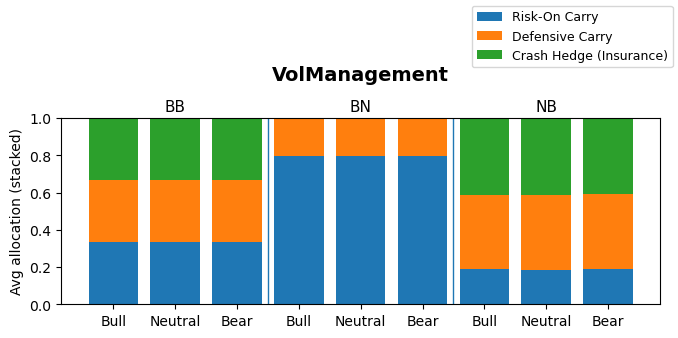

In [26]:
# plot
def _iter_payloads_volmanagement(nested_scenario):
    """
    nested_scenario[train_seed][test_seed] = payload
    """
    for _train_seed, by_test in nested_scenario.items():
        if not isinstance(by_test, dict):
            continue
        for _test_seed, payload in by_test.items():
            if isinstance(payload, dict):
                yield payload

def avg_allocations_by_regime_volmanagement(
    nested_scenario,
    weights_key="weights",
    regime_key="regime_days",):
    
    sum_w = None
    cnt = np.zeros(3, dtype=np.float64)

    for payload in _iter_payloads_volmanagement(nested_scenario):
        w = payload.get(weights_key, None)
        k = payload.get(regime_key, None)
        if w is None or k is None:
            continue

        w = np.asarray(w, dtype=np.float64)
        k = np.asarray(k, dtype=int)

        T = min(len(k), w.shape[0])
        if T <= 1:
            continue

        # drop t=0 initial condition
        w = w[1:T]
        k = k[1:T]

        N = w.shape[1]
        if sum_w is None:
            sum_w = np.zeros((3, N), dtype=np.float64)

        for reg in (0, 1, 2):
            mask = (k == reg)
            c = int(mask.sum())
            if c == 0:
                continue
            sum_w[reg] += w[mask].sum(axis=0)
            cnt[reg] += c

    if sum_w is None:
        raise ValueError("No usable payloads found (check keys/paths).")

    avg_w = sum_w / np.maximum(cnt[:, None], 1.0)

    avg_w = np.clip(avg_w, 0.0, np.inf)
    avg_w /= np.maximum(avg_w.sum(axis=1, keepdims=True), 1e-12)

    return avg_w


def plot_regime_allocations_volmanagement(
    oos_by_scenario,
    scenario_order=("BB", "BN", "NB"),
    regime_names=("Bull", "Neutral", "Bear"),
    asset_names=("Risk-On Carry", "Defensive Carry", "Crash Hedge (Insurance)"),
    title="Volatility Management",
):
    fig, ax = plt.subplots(1, 1, figsize=(6.8, 3.4), sharey=True)

    blocks = []
    for scen in scenario_order:
        avg_w = avg_allocations_by_regime_volmanagement(oos_by_scenario[scen])  # (3,N)
        blocks.append(avg_w)

    W = np.vstack(blocks)  # (9,N)
    N = W.shape[1]

    asset_names_plot = list(asset_names) if N == len(asset_names) else [f"Asset {i+1}" for i in range(N)]

    x = np.arange(9)
    bottom = np.zeros(9, dtype=float)

    for j in range(N):
        ax.bar(x, W[:, j], bottom=bottom, width=0.8, label=asset_names_plot[j])
        bottom += W[:, j]

    ax.set_ylim(0, 1.0)
    ax.set_ylabel("Avg allocation (stacked)")

    # bottom labels: Bull/Neutral/Bear repeated
    ax.set_xticks(x)
    ax.set_xticklabels(list(regime_names) * 3)

    # vertical separators between scenario groups
    ax.axvline(2.5, linewidth=1)
    ax.axvline(5.5, linewidth=1)

    for scen, cx in zip(scenario_order, [1, 4, 7]):
        ax.text(
            cx, 1.02, scen,
            ha="center", va="bottom",
            transform=ax.get_xaxis_transform(),
            fontsize=11
        )

    ax.text(
        0.5, 1.18, title,
        transform=ax.transAxes,
        ha="center", va="bottom",
        fontsize=14, fontweight="bold"
    )

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right", frameon=True, fontsize=9)

    fig.tight_layout(rect=[0, 0, 1, 0.90])
    plt.show()


plot_regime_allocations_volmanagement(
    oos_by_scenario,
    scenario_order=("BB","BN","NB"),
    regime_names=("Bull","Neutral","Bear"),
    asset_names=("Risk-On Carry", "Defensive Carry", "Crash Hedge (Insurance)"),
    title="VolManagement"
)


In [27]:
path_df = summarize_path_metrics_volmgmt_oos(
    oos_by_scenario=oos_by_scenario,
    periods_per_year=252,
    rf_annual=0.0,
    target=0.0,
    alpha=0.95,
    use_key="port_ret_net",
    REGIME_NAME=REGIME_NAME,
    policy_name="VolManagement",
)

metric_cols = [
    "Ann. Mean (%)","Ann. StdDev (%)","Ann. SemiDev (%)",
    "CVaR 95% (%)","Avg DD (%)","VaR 95% (%)",
    "Sharpe (ann.)","Sortino (ann.)",
    "Tail-Adj Sharpe (CVaR95)","Tail-Adj Sharpe (mVaR95)",
]

reg_only = path_df[path_df["Regime"].isin(["Bull","Neutral","Bear"])].copy()


regime_weighted = weighted_group_mean(
    reg_only,
    group_cols=["Scenario","Policy","Regime"],
    weight_col="N_obs",
    metric_cols=metric_cols
)
# we loose 16*time window many data points!!
regime_weighted

,Scenario,Policy,Regime,N_paths,SumWeights,Ann. Mean (%),Ann. StdDev (%),Ann. SemiDev (%),CVaR 95% (%),Avg DD (%),VaR 95% (%),Sharpe (ann.),Sortino (ann.),Tail-Adj Sharpe (CVaR95),Tail-Adj Sharpe (mVaR95)
0,BB,VolManagement,Bear,16,32036.0,17.530403,24.133000,15.753517,-2.549368,24.431473,-1.380077,-0.072220,0.302352,1.928500,-1.428169
1,BB,VolManagement,Bull,16,37572.0,13.944319,9.840143,10.109687,-1.382110,2.450345,-0.691198,1.740326,1.689735,12.141626,24.519102
2,BB,VolManagement,Neutral,16,10360.0,13.451600,11.859750,10.147724,-1.422269,2.666992,-0.616554,1.118939,1.219611,8.702998,11.093155
3,BN,VolManagement,Bear,16,1464.0,-29.540889,26.759743,23.773713,-3.454838,14.506505,-2.705481,-2.946108,-2.335234,-16.935564,-22.186628
4,BN,VolManagement,Bull,16,45388.0,27.887189,9.965381,10.471673,-1.425465,2.337142,-0.825972,2.906337,2.757379,20.404942,35.157073
5,BN,VolManagement,Neutral,16,33116.0,10.248299,21.457535,21.333109,-3.275359,21.719008,-1.826738,0.494076,0.498708,3.319625,6.008263
6,NB,VolManagement,Bear,16,39352.0,21.092377,25.599848,17.920831,-2.815558,17.913896,-1.523400,0.407762,0.746452,4.877225,10.231205
7,NB,VolManagement,Bull,16,5948.0,4.411550,15.691974,15.732058,-2.387958,5.378559,-1.188852,0.271503,0.304625,2.071340,3.738940
8,NB,VolManagement,Neutral,16,34668.0,11.286184,10.616092,9.767858,-1.412280,3.689007,-0.764010,1.077820,1.143921,7.870316,17.039352


In [28]:

regime_weighted = weighted_group_mean(
    reg_only,
    group_cols=["Policy","Regime"],
    weight_col="N_obs",
    metric_cols=metric_cols
)
# we loose 16*time window many data points!!
regime_weighted

,Policy,Regime,N_paths,SumWeights,Ann. Mean (%),Ann. StdDev (%),Ann. SemiDev (%),CVaR 95% (%),Avg DD (%),VaR 95% (%),Sharpe (ann.),Sortino (ann.),Tail-Adj Sharpe (CVaR95),Tail-Adj Sharpe (mVaR95)
0,VolManagement,Bear,48,72852.0,18.508529,24.978124,17.085391,-2.711350,20.711468,-1.484130,0.129297,0.489235,3.142211,4.452648
1,VolManagement,Bull,48,88908.0,20.424479,10.295569,10.670623,-1.471535,2.588454,-0.793294,2.237316,2.142108,15.686384,28.559636
2,VolManagement,Neutral,48,78144.0,11.133429,15.375376,14.719361,-2.203143,11.194298,-1.194826,0.835891,0.880526,6.052210,11.576257


In [29]:
# align
train_seeds = [53, 274, 1234, 89]   
test_seeds  = [1, 2, 3, 4]         

GAMMA      = 3.0
RIDGE      = 1e-8
C_TC       = 0.0001
VOL_WINDOW_21 = 21 # well... 21, 42, 63

TRAIN_T_DAYS = 252 * 30
TEST_T_DAYS  = 252 * 20

BURN_IN_TRAIN = 50
BURN_IN_TEST  = 0

START_DATE = "2000-01-03"

REGIME_NAME = {0: "Bull", 1: "Neutral", 2: "Bear"}


regime_names = ["Bull", "Neutral", "Bear"] # ! align with the parameters as intended.
asset_names  = ["Asset1_Growth", "Asset2_Carry", "Asset3_Defensive"]

# daily log-return drifts
const_k = np.array([
    [ 0.00105,  0.00028, -0.00018],  # Bull: A1 strong carry; A3 costs (insurance premium)
    [ 0.00045,  0.00022, -0.00008],  # Neutral: mild carry; A3 still costs a bit
    [-0.00180,  0.00008,  0.00055],  # Bear: A1 crashy; A3 pays; A2 small positive
], dtype=float)

Phi_fixed = np.array([
    [0.12, 0.04, 0.02],   # A1 depends mostly on own lag
    [0.03, 0.10, 0.02],   # A2 smaller own persistence than A!
    [0.02, 0.03, 0.08],   # A3 lowest persistence (insurance-like), rare events
], dtype=float)

Phi_k = np.tile(Phi_fixed, (3, 1, 1))

Sigma_k = np.array([
[[0.000220, 0.000080, -0.000030],
    [0.000080, 0.000100, -0.000010],
    [-0.000030,-0.000010, 0.000140]],

[[0.000320, 0.000110, -0.000035],
    [0.000110, 0.000130, -0.000015],
    [-0.000035,-0.000015, 0.000170]],

[[0.001500,-0.000150, -0.000650],
    [-0.000150,0.000220,  0.000020],
    [-0.000650,0.000020,  0.000500]],
], dtype=float)

df_list = np.array([18.0, 14.0, 8.0], dtype=float)         
logh_mu_list = np.array([-2.5, -2.2, -1.4], dtype=float)   
sv_rho, sv_sigma = 0.995, 0.18                             


Q_bull_bear = np.array([
[0.92, 0.04, 0.04],   # Bull mostly stays Bull, sometimes Neutral/Bear
[0.15, 0.70, 0.15],   # Neutral can go either way
[0.05, 0.05, 0.90],   # Bear persistent, occasional exit
]   , dtype=float)

# (BN) Bull-Neutral scenario: Bear is rare, Bull/Neutral are persistent
Q_bull_neutral = np.array([
    [0.94, 0.05, 0.01],   # Bull -> mostly Bull, some Neutral, very rare Bear
    [0.08, 0.90, 0.02],   # Neutral persistent, small chance Bull/Bear
    [0.20, 0.20, 0.60],   # if Bear happens, it can exit (not too sticky here)
], dtype=float)

# (NB) Neutral-Bear scenario: more time in Neutral/Bear, Bull less dominant
Q_neutral_bear = np.array([
    [0.75, 0.20, 0.05],   # Bull less persistent, drifts into Neutral/Bear
    [0.05, 0.85, 0.10],   # Neutral persistent, sometimes Bear
    [0.03, 0.07, 0.90],   # Bear persistent
], dtype=float)

targeted_scenarios = [
    dict(
        short="BB",
        name="VolTimingWorld_bull_bear",
        Q=Q_bull_bear, c=const_k, Sigma=Sigma_k,
        df_list=df_list, logh_mu_list=logh_mu_list,
        sv_rho=sv_rho, sv_sigma=sv_sigma,
    ),
    dict(
        short="BN",
        name="VolTimingWorld_bull_neutral",
        Q=Q_bull_neutral, c=const_k, Sigma=Sigma_k,
        df_list=df_list, logh_mu_list=logh_mu_list,
        sv_rho=sv_rho, sv_sigma=sv_sigma,
    ),
    dict(
        short="NB",
        name="VolTimingWorld_neutral_bear",
        Q=Q_neutral_bear, c=const_k, Sigma=Sigma_k,
        df_list=df_list, logh_mu_list=logh_mu_list,
        sv_rho=sv_rho, sv_sigma=sv_sigma,
    ),
]

oos_by_scenario = {}

for scen in targeted_scenarios:
    scen_key = scen["short"]   # "BB","BN","NB"
    print(f"\n=== Running OOS VolManagement for {scen_key}: {scen['name']} ===")

    oos_by_scenario[scen_key] = run_volmanagement_oos_for_scenario(
        scenario_name=scen["name"],
        Q_matrix=scen["Q"],
        c_list=scen["c"],
        Phi_k=Phi_k,
        Sigma_list=scen["Sigma"],
        regime_names=regime_names,
        asset_names=asset_names,
        df_list=scen["df_list"],
        logh_mu_list=scen["logh_mu_list"],
        sv_rho=scen["sv_rho"],
        sv_sigma=scen["sv_sigma"],
        train_seeds=train_seeds,
        test_seeds=test_seeds,
        train_T_days=TRAIN_T_DAYS,
        test_T_days=TEST_T_DAYS,
        burn_in_months_train=BURN_IN_TRAIN,
        burn_in_months_test=BURN_IN_TEST,
        start_date=START_DATE,
        gamma=GAMMA,
        ridge=RIDGE,
        c_tc=C_TC,
        vol_window=VOL_WINDOW_21,
        use_avg_vol_proxy=True,          # NEW
        use_assetwise_vol_proxy=False,    # NEW individual scaling
    )




=== Running OOS VolManagement for BB: VolTimingWorld_bull_bear ===

=== Running OOS VolManagement for BN: VolTimingWorld_bull_neutral ===

=== Running OOS VolManagement for NB: VolTimingWorld_neutral_bear ===


In [30]:
path_df = summarize_path_metrics_volmgmt_oos(
    oos_by_scenario=oos_by_scenario,
    periods_per_year=252,
    rf_annual=0.0,
    target=0.0,
    alpha=0.95,
    use_key="port_ret_net",
    REGIME_NAME=REGIME_NAME,
    policy_name="VolManagement",
)

metric_cols = [
    "Ann. Mean (%)","Ann. StdDev (%)","Ann. SemiDev (%)",
    "CVaR 95% (%)","Avg DD (%)","VaR 95% (%)",
    "Sharpe (ann.)","Sortino (ann.)",
    "Tail-Adj Sharpe (CVaR95)","Tail-Adj Sharpe (mVaR95)",
]

reg_only = path_df[path_df["Regime"].isin(["Bull","Neutral","Bear"])].copy()


regime_weighted = weighted_group_mean(
    reg_only,
    group_cols=["Scenario","Policy","Regime"],
    weight_col="N_obs",
    metric_cols=metric_cols
)
# we loose 16*time window many data points!!
regime_weighted

,Scenario,Policy,Regime,N_paths,SumWeights,Ann. Mean (%),Ann. StdDev (%),Ann. SemiDev (%),CVaR 95% (%),Avg DD (%),VaR 95% (%),Sharpe (ann.),Sortino (ann.),Tail-Adj Sharpe (CVaR95),Tail-Adj Sharpe (mVaR95)
0,BB,VolManagement,Bear,16,32036.0,17.530403,24.133000,15.753517,-2.549368,24.431473,-1.380077,-0.072220,0.302352,1.928500,-1.428169
1,BB,VolManagement,Bull,16,37824.0,14.005353,9.816066,10.089712,-1.377852,2.438787,-0.688345,1.756978,1.705376,12.265657,24.925555
2,BB,VolManagement,Neutral,16,10444.0,13.137997,11.796811,10.093369,-1.416589,2.641948,-0.615764,1.074680,1.179190,8.419667,10.696323
3,BN,VolManagement,Bear,16,1464.0,-29.646659,26.765036,23.792801,-3.457191,14.519195,-2.708972,-2.949525,-2.338937,-16.961394,-22.223874
4,BN,VolManagement,Bull,16,45640.0,28.054515,9.951579,10.454308,-1.421778,2.329708,-0.823350,2.930329,2.781611,20.609481,35.524064
5,BN,VolManagement,Neutral,16,33200.0,10.080200,21.455386,21.318124,-3.276908,21.667449,-1.827739,0.489688,0.494283,3.288921,5.943947
6,NB,VolManagement,Bear,16,39352.0,21.165197,25.513459,17.877185,-2.810510,17.980864,-1.523248,0.411888,0.750429,4.898605,10.152266
7,NB,VolManagement,Bull,16,6200.0,5.028917,15.412329,15.471000,-2.336218,5.216996,-1.151117,0.349250,0.380432,2.614575,4.683161
8,NB,VolManagement,Neutral,16,34752.0,11.220550,10.605865,9.749412,-1.411027,3.669528,-0.763249,1.071272,1.138175,7.827303,16.904837


In [31]:
regime_weighted = weighted_group_mean(
    reg_only,
    group_cols=["Policy","Regime"],
    weight_col="N_obs",
    metric_cols=metric_cols
)
# we loose 16*time window many data points!!
regime_weighted

,Policy,Regime,N_paths,SumWeights,Ann. Mean (%),Ann. StdDev (%),Ann. SemiDev (%),CVaR 95% (%),Avg DD (%),VaR 95% (%),Sharpe (ann.),Sortino (ann.),Tail-Adj Sharpe (CVaR95),Tail-Adj Sharpe (mVaR95)
0,VolManagement,Bear,48,72852.0,18.545738,24.931566,17.062199,-2.708671,20.747896,-1.484118,0.131457,0.491309,3.153241,4.409260
1,VolManagement,Bull,48,89664.0,20.535843,10.272008,10.647396,-1.466479,2.575369,-0.789063,2.256887,2.161576,15.845415,28.920616
2,VolManagement,Neutral,48,78396.0,10.993066,15.359199,14.694480,-2.201952,11.154590,-1.194403,0.825431,0.870957,5.984255,11.435894


In [32]:
# In the previous set up we recognized that  volatility timing is almost killed
# by the normalization
#  use_assetwise_vol_proxy=True

In [33]:
# align
train_seeds = [53, 274, 1234, 89]   
test_seeds  = [1, 2, 3, 4]         

GAMMA      = 3.0
RIDGE      = 1e-8
C_TC       = 0.0001
VOL_WINDOW = 21 # well... 21, 42, 63

TRAIN_T_DAYS = 252 * 30
TEST_T_DAYS  = 252 * 20

BURN_IN_TRAIN = 50
BURN_IN_TEST  = 0

START_DATE = "2000-01-03"

REGIME_NAME = {0: "Bull", 1: "Neutral", 2: "Bear"}


regime_names = ["Bull", "Neutral", "Bear"] # ! align with the parameters as intended.
asset_names  = ["Asset1_Growth", "Asset2_Carry", "Asset3_Defensive"]

# daily log-return drifts
const_k = np.array([
    [ 0.00105,  0.00028, -0.00018],  # Bull: A1 strong carry; A3 costs (insurance premium)
    [ 0.00045,  0.00022, -0.00008],  # Neutral: mild carry; A3 still costs a bit
    [-0.00180,  0.00008,  0.00055],  # Bear: A1 crashy; A3 pays; A2 small positive
], dtype=float)

Phi_fixed = np.array([
    [0.12, 0.04, 0.02],   # A1 depends mostly on own lag
    [0.03, 0.10, 0.02],   # A2 smaller own persistence than A!
    [0.02, 0.03, 0.08],   # A3 lowest persistence (insurance-like), rare events
], dtype=float)

Phi_k = np.tile(Phi_fixed, (3, 1, 1))

Sigma_k = np.array([
[[0.000220, 0.000080, -0.000030],
    [0.000080, 0.000100, -0.000010],
    [-0.000030,-0.000010, 0.000140]],

[[0.000320, 0.000110, -0.000035],
    [0.000110, 0.000130, -0.000015],
    [-0.000035,-0.000015, 0.000170]],

[[0.001500,-0.000150, -0.000650],
    [-0.000150,0.000220,  0.000020],
    [-0.000650,0.000020,  0.000500]],
], dtype=float)

df_list = np.array([18.0, 14.0, 8.0], dtype=float)         
logh_mu_list = np.array([-2.5, -2.2, -1.4], dtype=float)   
sv_rho, sv_sigma = 0.995, 0.18                             


Q_bull_bear = np.array([
[0.92, 0.04, 0.04],   # Bull mostly stays Bull, sometimes Neutral/Bear
[0.15, 0.70, 0.15],   # Neutral can go either way
[0.05, 0.05, 0.90],   # Bear persistent, occasional exit
]   , dtype=float)

# (BN) Bull-Neutral scenario: Bear is rare, Bull/Neutral are persistent
Q_bull_neutral = np.array([
    [0.94, 0.05, 0.01],   # Bull -> mostly Bull, some Neutral, very rare Bear
    [0.08, 0.90, 0.02],   # Neutral persistent, small chance Bull/Bear
    [0.20, 0.20, 0.60],   # if Bear happens, it can exit (not too sticky here)
], dtype=float)

# (NB) Neutral-Bear scenario: more time in Neutral/Bear, Bull less dominant
Q_neutral_bear = np.array([
    [0.75, 0.20, 0.05],   # Bull less persistent, drifts into Neutral/Bear
    [0.05, 0.85, 0.10],   # Neutral persistent, sometimes Bear
    [0.03, 0.07, 0.90],   # Bear persistent
], dtype=float)

targeted_scenarios = [
    dict(
        short="BB",
        name="VolTimingWorld_bull_bear",
        Q=Q_bull_bear, c=const_k, Sigma=Sigma_k,
        df_list=df_list, logh_mu_list=logh_mu_list,
        sv_rho=sv_rho, sv_sigma=sv_sigma,
    ),
    dict(
        short="BN",
        name="VolTimingWorld_bull_neutral",
        Q=Q_bull_neutral, c=const_k, Sigma=Sigma_k,
        df_list=df_list, logh_mu_list=logh_mu_list,
        sv_rho=sv_rho, sv_sigma=sv_sigma,
    ),
    dict(
        short="NB",
        name="VolTimingWorld_neutral_bear",
        Q=Q_neutral_bear, c=const_k, Sigma=Sigma_k,
        df_list=df_list, logh_mu_list=logh_mu_list,
        sv_rho=sv_rho, sv_sigma=sv_sigma,
    ),
]

oos_by_scenario_VOL_WINDOW_21_assetwise_vol_proxyT = {}

for scen in targeted_scenarios:
    scen_key = scen["short"]   # "BB","BN","NB"
    print(f"\n=== Running OOS VolManagement for {scen_key}: {scen['name']} ===")

    oos_by_scenario_VOL_WINDOW_21_assetwise_vol_proxyT[scen_key] = run_volmanagement_oos_for_scenario(
        scenario_name=scen["name"],
        Q_matrix=scen["Q"],
        c_list=scen["c"],
        Phi_k=Phi_k,
        Sigma_list=scen["Sigma"],
        regime_names=regime_names,
        asset_names=asset_names,
        df_list=scen["df_list"],
        logh_mu_list=scen["logh_mu_list"],
        sv_rho=scen["sv_rho"],
        sv_sigma=scen["sv_sigma"],
        train_seeds=train_seeds,
        test_seeds=test_seeds,
        train_T_days=TRAIN_T_DAYS,
        test_T_days=TEST_T_DAYS,
        burn_in_months_train=BURN_IN_TRAIN,
        burn_in_months_test=BURN_IN_TEST,
        start_date=START_DATE,
        gamma=GAMMA,
        ridge=RIDGE,
        c_tc=C_TC,
        vol_window=VOL_WINDOW,
        use_avg_vol_proxy=True,          # !!!!!
        use_assetwise_vol_proxy=True,    # !!!!!!!!
    )




=== Running OOS VolManagement for BB: VolTimingWorld_bull_bear ===

=== Running OOS VolManagement for BN: VolTimingWorld_bull_neutral ===

=== Running OOS VolManagement for NB: VolTimingWorld_neutral_bear ===


In [ ]:
# Average a_params and b_params across all train/test seeds for each scenario (VOL_WINDOW_21)

scenarios_to_check = ['BB', 'NB', 'BN']
avg_params_by_scenario_oos_21 = {}

for scenario_name in scenarios_to_check:
    if scenario_name not in oos_by_scenario_VOL_WINDOW_21_assetwise_vol_proxyT:
        continue
    
    a_params_list = []
    b_params_list = []
    
    for train_seed, test_seed_dict in oos_by_scenario_VOL_WINDOW_21_assetwise_vol_proxyT[scenario_name].items():
        for test_seed, result_dict in test_seed_dict.items():
            if 'a_params' in result_dict and 'b_params' in result_dict:
                a_params_list.append(result_dict['a_params'])
                b_params_list.append(result_dict['b_params'])
    
    a_df = pd.DataFrame(a_params_list)
    b_df = pd.DataFrame(b_params_list)
    
    avg_params_by_scenario_oos_21[scenario_name] = {
        'a_avg': a_df.mean(),
        'b_avg': b_df.mean()
    }
    
    print(f"\n{'='*60}")
    print(f"Scenario: {scenario_name} (VOL_WINDOW=21)")
    print(f"{'='*60}")
    print(f"\nAverage a_params (across {len(a_params_list)} train/test combinations):")
    print(avg_params_by_scenario_oos_21[scenario_name]['a_avg'].round(4))
    print(f"\nAverage b_params (across {len(b_params_list)} train/test combinations):")
    print(avg_params_by_scenario_oos_21[scenario_name]['b_avg'].round(4))



Scenario: BB (VOL_WINDOW=21)

Average a_params (across 16 train/test combinations):
Asset1_Growth       0.1667
Asset2_Carry        0.1667
Asset3_Defensive    0.1667
dtype: float64

Average b_params (across 16 train/test combinations):
Asset1_Growth       0.1667
Asset2_Carry        0.1667
Asset3_Defensive    0.1667
dtype: float64

Scenario: NB (VOL_WINDOW=21)

Average a_params (across 16 train/test combinations):
Asset1_Growth       0.1645
Asset2_Carry        0.1672
Asset3_Defensive    0.1683
dtype: float64

Average b_params (across 16 train/test combinations):
Asset1_Growth       0.0923
Asset2_Carry        0.2007
Asset3_Defensive    0.2050
dtype: float64

Scenario: BN (VOL_WINDOW=21)

Average a_params (across 16 train/test combinations):
Asset1_Growth       0.1671
Asset2_Carry        0.1664
Asset3_Defensive    0.1660
dtype: float64

Average b_params (across 16 train/test combinations):
Asset1_Growth       0.3949
Asset2_Carry        0.0981
Asset3_Defensive    0.0000
dtype: float64


In [34]:
# # Normalization kills everything i think, almost no change over regimes ( there is just minor)
# lets rebuild the normalized weights over time
payload = oos_by_scenario_VOL_WINDOW_21_assetwise_vol_proxyT["BN"][53][1]

a = payload["a_params"]
b = payload["b_params"]
vol_signal = payload["vol_signal"]

# Ensure vol_signal is DataFrame
if isinstance(vol_signal, pd.Series):
    vol_signal = vol_signal.to_frame()

# Calculate raw weights: a + b/vol, normalize
theta_raw = a + (b / vol_signal)
theta_norm = theta_raw.div(theta_raw.sum(axis=1), axis=0)

In [35]:
vol_signal

,Asset1_Growth,Asset2_Carry,Asset3_Defensive
2000-02-01,0.002364,0.001394,0.001742
2000-02-02,0.002394,0.001421,0.001745
2000-02-03,0.002325,0.001242,0.001750
2000-02-04,0.002383,0.001354,0.001638
2000-02-07,0.002442,0.001365,0.001650
...,...,...,...
2019-04-22,0.002385,0.001637,0.001526
2019-04-23,0.002378,0.001637,0.001532
2019-04-24,0.002373,0.001576,0.001511
2019-04-25,0.002378,0.001578,0.001497


In [36]:
a_vec

Asset1_Growth       0.166154
Asset2_Carry        0.166026
Asset3_Defensive    0.167856
Name: a, dtype: float64

In [37]:
b_vec

Asset1_Growth       3.810053e-01
Asset2_Carry        1.135261e-01
Asset3_Defensive    6.938894e-17
Name: b, dtype: float64

In [38]:
theta_raw

,Asset1_Growth,Asset2_Carry,Asset3_Defensive
2000-02-01,161.506003,81.322515,0.168192
2000-02-02,159.481282,79.780166,0.168192
2000-02-03,164.213201,91.226474,0.168192
2000-02-04,160.170670,83.700989,0.168192
2000-02-07,156.318839,83.052053,0.168192
...,...,...,...
2019-04-22,160.068916,69.286656,0.168192
2019-04-23,160.528317,69.257992,0.168192
2019-04-24,160.863134,71.960119,0.168192
2019-04-25,160.534387,71.853146,0.168192


In [39]:
theta_norm

,Asset1_Growth,Asset2_Carry,Asset3_Defensive
2000-02-01,0.664643,0.334665,0.000692
2000-02-02,0.666088,0.333209,0.000702
2000-02-03,0.642442,0.356900,0.000658
2000-02-04,0.656330,0.342981,0.000689
2000-02-07,0.652582,0.346716,0.000702
...,...,...,...
2019-04-22,0.697396,0.301871,0.000733
2019-04-23,0.698087,0.301181,0.000731
2019-04-24,0.690425,0.308853,0.000722
2019-04-25,0.690305,0.308972,0.000723


In [40]:
path_df_oos_by_scenario_VOL_WINDOW_21_assetwise_vol_proxyT = summarize_path_metrics_volmgmt_oos(
    oos_by_scenario=oos_by_scenario_VOL_WINDOW_21_assetwise_vol_proxyT,
    periods_per_year=252,
    rf_annual=0.0,
    target=0.0,
    alpha=0.95,
    use_key="port_ret_net",
    REGIME_NAME=REGIME_NAME,
    policy_name="VolManagement",
)

metric_cols = [
    "Ann. Mean (%)","Ann. StdDev (%)","Ann. SemiDev (%)",
    "CVaR 95% (%)","Avg DD (%)","VaR 95% (%)",
    "Sharpe (ann.)","Sortino (ann.)",
    "Tail-Adj Sharpe (CVaR95)","Tail-Adj Sharpe (mVaR95)",
]

reg_only = path_df_oos_by_scenario_VOL_WINDOW_21_assetwise_vol_proxyT[path_df_oos_by_scenario_VOL_WINDOW_21_assetwise_vol_proxyT["Regime"].isin(["Bull","Neutral","Bear"])].copy()


regime_weighted = weighted_group_mean(
    reg_only,
    group_cols=["Scenario","Policy","Regime"],
    weight_col="N_obs",
    metric_cols=metric_cols
)
# we loose 16*time window many data points!!
regime_weighted

,Scenario,Policy,Regime,N_paths,SumWeights,Ann. Mean (%),Ann. StdDev (%),Ann. SemiDev (%),CVaR 95% (%),Avg DD (%),VaR 95% (%),Sharpe (ann.),Sortino (ann.),Tail-Adj Sharpe (CVaR95),Tail-Adj Sharpe (mVaR95)
0,BB,VolManagement,Bear,16,32036.0,22.300983,22.721182,14.602813,-2.286815,12.024833,-1.209765,0.406749,0.857983,5.625361,355.788820
1,BB,VolManagement,Bull,16,37824.0,11.817999,9.478367,9.886609,-1.352744,2.739299,-0.679612,1.537181,1.496937,10.649188,18.747684
2,BB,VolManagement,Neutral,16,10444.0,12.863700,11.262023,9.586610,-1.334426,2.372296,-0.567222,1.057692,1.167818,8.443237,10.310942
3,BN,VolManagement,Bear,16,1464.0,-20.172704,21.879953,19.255006,-2.752731,11.882002,-2.142346,-2.542943,-2.054599,-14.617262,-20.045285
4,BN,VolManagement,Bull,16,45640.0,26.552320,9.637462,10.130558,-1.377740,2.323396,-0.801771,2.859195,2.709283,20.086925,34.654389
5,BN,VolManagement,Neutral,16,33200.0,10.032515,20.481236,20.357757,-3.131817,20.776687,-1.749515,0.510271,0.515983,3.426012,6.173381
6,NB,VolManagement,Bear,16,39352.0,22.807576,25.214880,17.917137,-2.777346,11.396207,-1.487111,0.600391,0.943254,6.148006,18.687333
7,NB,VolManagement,Bull,16,6200.0,0.918591,14.817288,15.665837,-2.391179,6.242349,-1.135550,0.171347,0.195457,1.335580,2.117374
8,NB,VolManagement,Neutral,16,34752.0,10.941586,10.419187,9.524753,-1.377181,3.745356,-0.735839,1.041908,1.112043,7.646597,15.363751


In [41]:

regime_weighted = weighted_group_mean(
    reg_only,
    group_cols=["Policy","Regime"],
    weight_col="N_obs",
    metric_cols=metric_cols
)
# we loose 16*time window many data points!!
regime_weighted

,Policy,Regime,N_paths,SumWeights,Ann. Mean (%),Ann. StdDev (%),Ann. SemiDev (%),CVaR 95% (%),Avg DD (%),VaR 95% (%),Sharpe (ann.),Sortino (ann.),Tail-Adj Sharpe (CVaR95),Tail-Adj Sharpe (mVaR95)
0,VolManagement,Bear,48,72852.0,21.721094,24.051282,16.486579,-2.561144,11.682402,-1.378318,0.452071,0.845514,5.500888,166.146273
1,VolManagement,Bull,48,89664.0,18.564275,9.928519,10.410398,-1.437272,2.769825,-0.773319,2.115658,2.024041,14.809095,25.694442
2,VolManagement,Neutral,48,78396.0,10.812669,14.792658,14.120673,-2.114557,10.775051,-1.142659,0.818867,0.867047,5.965346,10.798571


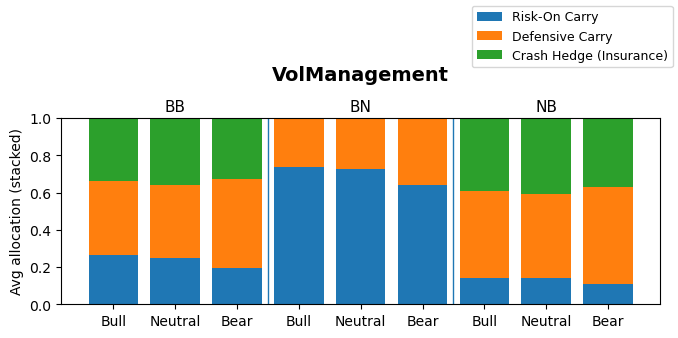

In [42]:
# plot


plot_regime_allocations_volmanagement(
    oos_by_scenario_VOL_WINDOW_21_assetwise_vol_proxyT,
    scenario_order=("BB","BN","NB"),
    regime_names=("Bull","Neutral","Bear"),
    asset_names=("Risk-On Carry", "Defensive Carry", "Crash Hedge (Insurance)"),
    title="VolManagement"
)


In [43]:
VOL_WINDOW  = 42
oos_by_scenario_VOL_WINDOW_42_assetwise_vol_proxyT = {}

for scen in targeted_scenarios:
    scen_key = scen["short"]   # "BB","BN","NB"
    print(f"\n=== Running OOS VolManagement for {scen_key}: {scen['name']} ===")

    oos_by_scenario_VOL_WINDOW_42_assetwise_vol_proxyT[scen_key] = run_volmanagement_oos_for_scenario(
        scenario_name=scen["name"],
        Q_matrix=scen["Q"],
        c_list=scen["c"],
        Phi_k=Phi_k,
        Sigma_list=scen["Sigma"],
        regime_names=regime_names,
        asset_names=asset_names,
        df_list=scen["df_list"],
        logh_mu_list=scen["logh_mu_list"],
        sv_rho=scen["sv_rho"],
        sv_sigma=scen["sv_sigma"],
        train_seeds=train_seeds,
        test_seeds=test_seeds,
        train_T_days=TRAIN_T_DAYS,
        test_T_days=TEST_T_DAYS,
        burn_in_months_train=BURN_IN_TRAIN,
        burn_in_months_test=BURN_IN_TEST,
        start_date=START_DATE,
        gamma=GAMMA,
        ridge=RIDGE,
        c_tc=C_TC,
        vol_window=VOL_WINDOW,
        use_avg_vol_proxy=True,         
        use_assetwise_vol_proxy=True,    
    )




=== Running OOS VolManagement for BB: VolTimingWorld_bull_bear ===

=== Running OOS VolManagement for BN: VolTimingWorld_bull_neutral ===

=== Running OOS VolManagement for NB: VolTimingWorld_neutral_bear ===


In [55]:
oos_by_scenario_VOL_WINDOW_42_assetwise_vol_proxyT['BB'][53][1].keys()

dict_keys(['port_ret_net', 'regime_days', 'weights', 'turnover', 'costs', 'vol_signal', 'a_params', 'b_params'])

In [56]:
# Average a_params and b_params across all train/test seeds for each scenario
import pandas as pd

scenarios_to_check = ['BB', 'NB', 'BN']
avg_params_by_scenario_oos = {}

for scenario_name in scenarios_to_check:
    if scenario_name not in oos_by_scenario_VOL_WINDOW_42_assetwise_vol_proxyT:
        continue
    
    a_params_list = []
    b_params_list = []
    
    # Iterate over all train seeds and test seeds
    for train_seed, test_seed_dict in oos_by_scenario_VOL_WINDOW_42_assetwise_vol_proxyT[scenario_name].items():
        for test_seed, result_dict in test_seed_dict.items():
            if 'a_params' in result_dict and 'b_params' in result_dict:
                a_params_list.append(result_dict['a_params'])
                b_params_list.append(result_dict['b_params'])
    
    # Convert to DataFrame and compute mean
    a_df = pd.DataFrame(a_params_list)
    b_df = pd.DataFrame(b_params_list)
    
    avg_params_by_scenario_oos[scenario_name] = {
        'a_avg': a_df.mean(),
        'b_avg': b_df.mean()
    }
    
    print(f"\n{'='*60}")
    print(f"Scenario: {scenario_name}")
    print(f"{'='*60}")
    print(f"\nAverage a_params (across {len(a_params_list)} train/test combinations):")
    print(avg_params_by_scenario_oos[scenario_name]['a_avg'].round(4))
    print(f"\nAverage b_params (across {len(b_params_list)} train/test combinations):")
    print(avg_params_by_scenario_oos[scenario_name]['b_avg'].round(4))


Scenario: BB

Average a_params (across 16 train/test combinations):
Asset1_Growth       0.1667
Asset2_Carry        0.1667
Asset3_Defensive    0.1667
dtype: float64

Average b_params (across 16 train/test combinations):
Asset1_Growth       0.1667
Asset2_Carry        0.1667
Asset3_Defensive    0.1667
dtype: float64

Scenario: NB

Average a_params (across 16 train/test combinations):
Asset1_Growth       0.1646
Asset2_Carry        0.1671
Asset3_Defensive    0.1682
dtype: float64

Average b_params (across 16 train/test combinations):
Asset1_Growth       0.0923
Asset2_Carry        0.2009
Asset3_Defensive    0.2048
dtype: float64

Scenario: BN

Average a_params (across 16 train/test combinations):
Asset1_Growth       0.1674
Asset2_Carry        0.1663
Asset3_Defensive    0.1658
dtype: float64

Average b_params (across 16 train/test combinations):
Asset1_Growth       0.3943
Asset2_Carry        0.0987
Asset3_Defensive    0.0000
dtype: float64


In [44]:
# # Normalization kills everything i think, almost no change over regimes ( there is just minor)
# lets rebuild the normalized weights over time
payload = oos_by_scenario_VOL_WINDOW_42_assetwise_vol_proxyT["BN"][53][1]

a = payload["a_params"]
b = payload["b_params"]
vol_signal = payload["vol_signal"]

# Ensure vol_signal is DataFrame
if isinstance(vol_signal, pd.Series):
    vol_signal = vol_signal.to_frame()

# Calculate raw weights: a + b/vol, normalize
theta_raw = a + (b / vol_signal)
theta_norm = theta_raw.div(theta_raw.sum(axis=1), axis=0)

In [45]:
vol_signal

,Asset1_Growth,Asset2_Carry,Asset3_Defensive
2000-03-01,0.002464,0.001498,0.001647
2000-03-02,0.002456,0.001505,0.001652
2000-03-03,0.002347,0.001391,0.001673
2000-03-06,0.002383,0.001482,0.001606
2000-03-07,0.002439,0.001501,0.001604
...,...,...,...
2019-04-22,0.001924,0.001234,0.001197
2019-04-23,0.001925,0.001234,0.001201
2019-04-24,0.002032,0.001244,0.001198
2019-04-25,0.002036,0.001248,0.001204


In [46]:
path_df_oos_by_scenario_VOL_WINDOW_42_assetwise_vol_proxyT = summarize_path_metrics_volmgmt_oos(
    oos_by_scenario=oos_by_scenario_VOL_WINDOW_42_assetwise_vol_proxyT,
    periods_per_year=252,
    rf_annual=0.0,
    target=0.0,
    alpha=0.95,
    use_key="port_ret_net",
    REGIME_NAME=REGIME_NAME,
    policy_name="VolManagement",
)

metric_cols = [
    "Ann. Mean (%)","Ann. StdDev (%)","Ann. SemiDev (%)",
    "CVaR 95% (%)","Avg DD (%)","VaR 95% (%)",
    "Sharpe (ann.)","Sortino (ann.)",
    "Tail-Adj Sharpe (CVaR95)","Tail-Adj Sharpe (mVaR95)",
]

reg_only = path_df_oos_by_scenario_VOL_WINDOW_42_assetwise_vol_proxyT[path_df_oos_by_scenario_VOL_WINDOW_42_assetwise_vol_proxyT["Regime"].isin(["Bull","Neutral","Bear"])].copy()


regime_weighted = weighted_group_mean(
    reg_only,
    group_cols=["Scenario","Policy","Regime"],
    weight_col="N_obs",
    metric_cols=metric_cols
)
# we loose 16*time window many data points!!
regime_weighted

,Scenario,Policy,Regime,N_paths,SumWeights,Ann. Mean (%),Ann. StdDev (%),Ann. SemiDev (%),CVaR 95% (%),Avg DD (%),VaR 95% (%),Sharpe (ann.),Sortino (ann.),Tail-Adj Sharpe (CVaR95),Tail-Adj Sharpe (mVaR95)
0,BB,VolManagement,Bear,16,32036.0,22.598216,22.113398,14.548762,-2.267236,11.808439,-1.193036,0.453559,0.880856,5.816073,35.199605
1,BB,VolManagement,Bull,16,37572.0,11.639691,9.538240,9.996530,-1.360738,2.831875,-0.674888,1.523047,1.476666,10.550086,18.582633
2,BB,VolManagement,Neutral,16,10360.0,13.381343,11.135134,9.292665,-1.304475,2.504192,-0.565009,1.101986,1.248251,9.012830,10.684969
3,BN,VolManagement,Bear,16,1464.0,-20.533829,22.222446,19.610409,-2.815286,12.178465,-2.197944,-2.611405,-2.092618,-14.810093,-20.642258
4,BN,VolManagement,Bull,16,45388.0,26.342444,9.641388,10.139902,-1.380767,2.333502,-0.803193,2.832989,2.684761,19.865941,34.225986
5,BN,VolManagement,Neutral,16,33116.0,10.384586,20.488409,20.341445,-3.122641,20.135794,-1.747904,0.519391,0.526240,3.493299,6.332860
6,NB,VolManagement,Bear,16,39352.0,22.802367,24.797587,17.877972,-2.762374,11.286910,-1.478103,0.616213,0.945971,6.190675,47.975266
7,NB,VolManagement,Bull,16,5948.0,-1.057076,15.148922,16.138649,-2.477016,6.946585,-1.227350,0.066957,0.097196,0.624307,0.972888
8,NB,VolManagement,Neutral,16,34668.0,11.059578,10.363369,9.473946,-1.364662,3.832361,-0.737260,1.054094,1.127413,7.791970,15.905523


In [47]:

regime_weighted = weighted_group_mean(
    reg_only,
    group_cols=["Policy","Regime"],
    weight_col="N_obs",
    metric_cols=metric_cols
)
# we loose 16*time window many data points!!
regime_weighted

,Policy,Regime,N_paths,SumWeights,Ann. Mean (%),Ann. StdDev (%),Ann. SemiDev (%),CVaR 95% (%),Avg DD (%),VaR 95% (%),Sharpe (ann.),Sortino (ann.),Tail-Adj Sharpe (CVaR95),Tail-Adj Sharpe (mVaR95)
0,VolManagement,Bear,48,72852.0,21.841729,23.565490,16.448797,-2.545705,11.534164,-1.367213,0.479827,0.856275,5.603925,40.978380
1,VolManagement,Bull,48,88908.0,18.296102,9.966256,10.480634,-1.445643,2.852729,-0.777349,2.094366,2.001118,14.641838,25.390544
2,VolManagement,Neutral,48,78144.0,11.081339,14.756493,14.055360,-2.101682,10.565375,-1.142716,0.833846,0.888667,6.132128,11.156684


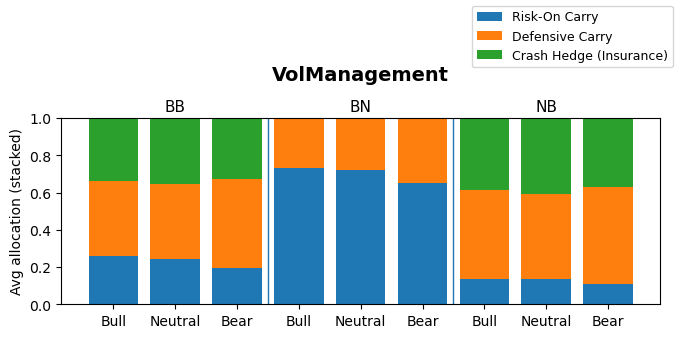

In [48]:


plot_regime_allocations_volmanagement(
    oos_by_scenario_VOL_WINDOW_42_assetwise_vol_proxyT,
    scenario_order=("BB","BN","NB"),
    regime_names=("Bull","Neutral","Bear"),
    asset_names=("Risk-On Carry", "Defensive Carry", "Crash Hedge (Insurance)"),
    title="VolManagement"
)
